In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import csv
import os
import seaborn as sns
import copy
import time
from itertools import cycle, islice
import math
from operator import add

import keras
import keras.backend.tensorflow_backend as backend
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras import optimizers
from keras.callbacks import TensorBoard
import tensorflow as tf
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import pydot as pyd

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Using TensorFlow backend.


In [2]:
%%time
epsilon = 1
decay = 0.9998
episodes = 4000
for i in range(episodes):
    epsilon*=decay
print(epsilon)

0.4492930144447668
Wall time: 996 µs


In [3]:
SIZE_X = 35
SIZE_Y = 20

In [4]:
class HeatMapManager:
    def __init__(self, mapLabel = "", heatMap = None):
        self.heatMap = heatMap
        self.label = mapLabel
    
    def addEvent(self, x = -1, y = -1, value = 1):
        self.heatMap[x][y]+=value
    
    def getMatrix(self):
        return self.heatMap
    
    def getMaxValue(self):
        return np.amax(self.getMatrix())
    
    def getMinValue(self):
        return np.amin(self.getMatrix())
    
    def reset(self):
        self.heatMap = np.zeros((SIZE_X, SIZE_Y))
    
    def populate(self, data, xLabel = 'X', yLabel = 'Y'):
        data = data[[xLabel, yLabel]]
        data["Count"] = 1
        data = data.groupby([xLabel, yLabel], as_index = False).sum()
        for index, row in data.iterrows():
            x = row[xLabel]
            y = row[yLabel]
            count = row["Count"]
            self.addEvent(x, y, count)
    
    def power(self, exponent):
        self.heatMap = np.power(self.heatMap, exponent)
    
    def squareRoot(self):
        self.heatMap = np.sqrt(self.heatMap)
        
    def cubeRoot(self):
        self.heatMap = np.cbrt(self.heatMap)
    
    # Returns a figure with 1 axes object (the heatmap)
    def render(self, title = "", color = "copper", scaleMax = None, scaleMin = None):
        plt.close('all')
        plt.style.use('default')
        figure = plt.figure(1)
        renderMap = self.getMatrix().transpose()
        if scaleMax != None and scaleMin != None:
            ax = sns.heatmap(renderMap, cmap = color, vmax = scaleMax, vmin = scaleMin)
        elif scaleMax != None:
            ax = sns.heatmap(renderMap, cmap = color, vmax = scaleMax)
        elif scaleMin != None:
            ax = sns.heatmap(renderMap, cmap = color, vmin = scaleMin)
        else:
            ax = sns.heatmap(renderMap, cmap = color)
        ax.invert_yaxis()
        if not title == "":
            plt.title(title, fontsize = 12)
        return figure
    
    # Print numerical version of heatmap
    def printMap(self, toPrint = None):
        if toPrint == None:
            toPrint = self.heatMap[:][:][:]
        copy = toPrint
        if copy.ndim >= 3:
            copy = np.swapaxes(copy,1,2)
        if copy.ndim >= 2:
            copy = np.swapaxes(copy,0,1)
        print(copy)
        
class MultiHeatMapManager:
    def __init__(self):
        self.heatMapManagerList = []
        
    def add(self, heatMapManager):
        self.heatMapManagerList.append(heatMapManager)
    
    def remove(self, index = -1):
        del self.heatMapMangerList[index]
    
    def get(self, index):
        return self.heatMapManagerList[index]
    
    #Finds the max value amongst all heatMap data
    def getMaxValueFromAllHeatMaps(self):
        maxValue = 0
        for eachMap in self.heatMapManagerList:
            eachMapMaxValue = eachMap.getMaxValue()
            if eachMapMaxValue > maxValue:
                maxValue = eachMapMaxValue
        return maxValue
    
    #Finds the min value amongst all heatMap data
    def getMinValueFromAllHeatMaps(self):
        minValue = 0
        for eachMap in self.heatMapManagerList:
            eachMapMinValue = eachMap.getMinValue()
            if eachMapMinValue < minValue:
                minValue = eachMapMinValue
        return minValue
    
    #Renders a list of heatmaps as 1 figure
    def render(self, uniformScale = False, color = "copper", scaleMax = None, scaleMin = None):
        imageScale = 1/5
        heatMapCount = len(self.heatMapManagerList)
        rowCount = 2
        columnCount = (heatMapCount+1)//2
        
        plt.close('all')
        plt.style.use('default')
        fig = plt.figure(figsize=(SIZE_X*imageScale*columnCount,SIZE_Y*imageScale*rowCount))
        fig.subplots_adjust(hspace=0.3, wspace=0.1)#bookmark tinkering
        axisID = 1
        for eachMap in self.heatMapManagerList:
            renderMap = eachMap.getMatrix().transpose()
            currentAxis = fig.add_subplot(rowCount, columnCount, axisID)
            if uniformScale:
                if scaleMax != None:
                    maxValue = scaleMax
                else:
                    maxValue = self.getMaxValueFromAllHeatMaps()
                if scaleMin != None:
                    minValue = scaleMin
                else:
                    minValue = self.getMinValueFromAllHeatMaps()
                sns.heatmap(renderMap, ax=currentAxis, cmap=color, vmin = minValue, vmax = maxValue).invert_yaxis()
            else:
                if scaleMax != None and scaleMin != None:
                    sns.heatmap(renderMap, ax=currentAxis, cmap=color, vmin = scaleMin, vmax = scaleMax).invert_yaxis()
                elif scaleMax != None:
                    sns.heatmap(renderMap, ax=currentAxis, cmap=color, vmax = scaleMax).invert_yaxis()
                elif scaleMin != None:
                    sns.heatmap(renderMap, ax=currentAxis, cmap=color, vmin = scaleMin).invert_yaxis()
                else:
                    sns.heatmap(renderMap, ax=currentAxis, cmap=color).invert_yaxis()
            plt.title(f"{eachMap.label}", fontsize = 12)
            #aspectRatio = SIZE_X/SIZE_Y
            #currentAxis.set_aspect(aspect = aspectRatio, adjustable = 'datalim')
            axisID+=1
        return fig

In [5]:
class AgentDataManager:
    def __init__(self, agentData, runName = ""):
        self.originalAgentData = agentData
        self.savedAgentData = None
        self.agentData = agentData
        self.runName = runName
        self.roomList = []
        
    
    def sixRoomConfiguration(self):
        #ID, left, right, top, bottom
        self.roomList = []
        self.roomList.append(Room(0, 0, 34, 10, 9))#corridor
        self.roomList.append(Room(1, 0, 10, 19, 11))#top left
        self.roomList.append(Room(2, 11, 23, 19, 11))#top center
        self.roomList.append(Room(3, 24, 34, 19, 11))#top right
        self.roomList.append(Room(4, 0, 10, 8, 0))#bottom left
        self.roomList.append(Room(5, 11, 23, 8, 0))#bottom center
        self.roomList.append(Room(6, 24, 34, 8, 0))#bottom right
        
    def fourRoomConfiguration(self):
        #ID, left, right, top, bottom
        self.roomList = []
        self.roomList.append(Room(0, 0, 34, 10, 9))#corridor
        self.roomList.append(Room(1, 0, 16, 19, 12))#top left
        self.roomList.append(Room(2, 18, 34, 19, 12))#top right
        self.roomList.append(Room(3, 0, 16, 7, 0))#bottom left
        self.roomList.append(Room(4, 18, 34, 7, 0))#bottom right
    
    def getRunName(self):
        return self.runName
        
    def save(self):
        self.savedAgentData = self.agentData
    
    def load(self):
        self.agentData = self.savedAgentData
    
    def reset(self):
        self.agentData = self.originalAgentData
    
    def getData(self):
        return self.agentData
    
    def getOriginalData(self):
        return self.originalAgentData
    
    # columnName = Episode, AgentID, X, or Y
    def getMax(self, columnName = 'Episode', data = None):
        if data is None:
            return np.amax(self.agentData[columnName])
        else:
            return np.amax(data[columnName])
        
    # columnName = Episode, AgentID, X, or Y
    def getMin(self, columnName = 'Episode', data = None):
        if data is None:
            return np.amin(self.agentData[columnName])
        else:
            return np.amin(data[columnName])
        
    def setDataWithTheseCoordinates(self, x = -1, y = -1):
        data = self.agentData
        dataWithX = self.getDataWithThisXcoord(data, x)
        dataWithXandY = self.getDataWithThisYcoord(dataWithX, y)
        self.agentData = dataWithXandY
    
    def getDataWithTheseCoordinates(self, data, x = -1, y = -1):
        dataWithX = self.getDataWithThisXcoord(data, x)
        dataWithXandY = self.getDataWithThisYcoord(dataWithX, y)
        return dataWithXandY
    
    def setDataToIgnoreCorridor(self):
        data = self.agentData
        data = data.loc[data['Y'] != 10]
        self.agentData = data.loc[data['Y'] != 9]
    
    def setDataWithMoreThanThisXcoord(self, x = -1):
        data = self.agentData
        self.agentData = data.loc[data['X'] > x]
    
    def setDataWithLessThanThisXcoord(self, x = -1):
        data = self.agentData
        self.agentData = data.loc[data['X'] < x]
        
    def setDataWithMoreThanThisYcoord(self, y = -1):
        data = self.agentData
        self.agentData = data.loc[data['Y'] > y]
    
    def setDataWithLessThanThisYcoord(self, y = -1):
        data = self.agentData
        self.agentData = data.loc[data['Y'] < y]
        
    def setDataWithThisXcoord(self, x = -1):
        data = self.agentData
        self.agentData = data.loc[data['X'] == x]
    
    def getDataWithThisXcoord(self, data, x = -1):
        return data.loc[data['X'] == x]
    
    def setDataWithThisYcoord(self, y = -1):
        data = self.agentData
        self.agentData = data.loc[data['Y'] == y]
        
    def getDataWithThisYcoord(self, data, y = -1):
        return data.loc[data['Y'] == y]
    
    #thisEvent: Move, AgentC, WallC, Task
    def setDataWithThisEvent(self, thisEvent = "-1"):
        data = self.agentData
        self.agentData = data.loc[data['Event'] == thisEvent]
    
    #thisEvent: Move, AgentC, WallC, Task
    def getDataWithThisEvent(self, data, thisEvent = "-1"):
        return data.loc[data['Event'] == thisEvent]
    
    #theseIDs is a list of agent ID numbers
    def setDataWithTheseIDs(self, theseIDs = -1):
        data = self.agentData
        self.agentData = data.loc[data['AgentID'].isin(theseIDs)]
    
    def getDataWithThisStep(self, data, stepNum = -1):
        return data.loc[data['Step'] == stepNum]
    
    #theseIDs is a list of agent ID numbers
    def getDataWithTheseIDs(self, data, theseIDs = -1):
        return data.loc[data['AgentID'].isin(theseIDs)]
    
    def setDataBetweenEpisodes(self, startEpisode, endEpisode):
        if startEpisode == endEpisode:
            self.setDataWithEpisode(startEpisode)
        else:
            dataFromStartEpisode = self.getDataWithEpisodesFrom(self.agentData, startEpisode)
            dataBetweenEpisodes = self.getDataWithEpisodesUntil(dataFromStartEpisode, endEpisode)
            self.agentData = dataBetweenEpisodes
    
    def getDataBetweenEpisodes(self, data, startEpisode, endEpisode):
        if startEpisode == endEpisode:
            dataBetweenEpisodes = self.getDataWithEpisode(data, startEpisode)
        else:
            dataFromStartEpisode = self.getDataWithEpisodesFrom(data, startEpisode)
            dataBetweenEpisodes = self.getDataWithEpisodesUntil(dataFromStartEpisode, endEpisode)
        return dataBetweenEpisodes
    
    def setDataWithEpisode(self, episode):
        data = self.agentData
        self.agentData = data.loc[data['Episode'] == episode]
    
    def getDataWithEpisode(self, data, episode):
        return data.loc[data['Episode'] == episode]
    
    def setDataWithEpisodesFrom(self, episode):
        data = self.agentData
        self.agentData = data.loc[data['Episode'] >= episode]
    
    def getDataWithEpisodesFrom(self, data, episode):
        return data.loc[data['Episode'] >= episode]
    
    def setDataWithEpisodesUntil(self, episode):
        data = self.agentData
        self.agentData = data.loc[data['Episode'] <= episode]
    
    def getDataWithEpisodesUntil(self, data, episode):
        return data.loc[data['Episode'] <= episode]
    
    def getEachAgentData(self, agentCount):
        eachAgentDataList = []
        for agentID in range(0, agentCount):
            eachAgentDataList.append(self.getDataOfAgent(agentID))
        return eachAgentDataList
    
    def getDataOfAgent(self, agentID, useThisData = None):
        if useThisData is None:
            data = self.agentData
        else:
            data = useThisData
        oneAgentData = data.loc[data["AgentID"] == agentID]
        return oneAgentData
    
    def getOneHotEncodedData(self, columnName = "Event"):
        data = self.agentData
        categoricalObject = pd.Categorical(data[columnName])
        return pd.get_dummies(categoricalObject)
    
    #For multiple episodes, returns the average
    def getEventPerStep(self, event = "AgentC"):
        stepCount = self.getMax("Step")
        eventOccurenceForEachStep = [0] * stepCount
        countedEpisodes = []
        for index, row in self.agentData.iterrows():
            episode = row["Episode"]
            if not episode in countedEpisodes:
                countedEpisodes.append(episode)
            
            eventData = row["Event"]
            if eventData == event:
                step = row["Step"]
                eventOccurenceForEachStep[step-1] += 1
        
        averagedEventOccurenceForEachStep = [eachStep/len(countedEpisodes) for eachStep in eventOccurenceForEachStep]
        return averagedEventOccurenceForEachStep
    
    def getTasksCompletedInEachRoomData(self, roomArangement = "Six Room"):
        if roomArangement == "Six Room":
            self.sixRoomConfiguration()
        elif roomArangement == "Four Room":
            self.fourRoomConfiguration()
        
        roomCount = len(self.roomList)
        tasksCompletedForEachRoom = [0] * roomCount
        self.setDataWithThisEvent("Task")
        for index, row in self.agentData.iterrows():
            agentX = row["X"]
            agentY = row["Y"]
            roomNum = self.getRoomFromCoordinates(agentX, agentY)
            if roomNum == 0:
                print("(",agentX, ",", agentY,")")#bookmark debug
                print("Episode", row["Episode"])
                print("Step", row["Step"])
            if roomNum != -1:
                tasksCompletedForEachRoom[roomNum] += 1
                
        return tasksCompletedForEachRoom
            
        
    def getTimeSpentWithOneAgentVersusMultipleAgentsInEachRoomData(self, roomArangement = "Six Room"):
        if roomArangement == "Six Room":
            self.sixRoomConfiguration()
        elif roomArangement == "Four Room":
            self.fourRoomConfiguration()
        
        roomCount = len(self.roomList)
        agentCount = self.getMax("AgentID")+1
        
        singleAgentTimeForEachRoom = []
        multiAgentTimeForEachRoom = []
        for i in range(roomCount):
            singleAgentTimeForEachRoom.append(0)
            multiAgentTimeForEachRoom.append(0)
        
        roomOfEachAgent = []
        for index, row in self.agentData.iterrows():
            if len(roomOfEachAgent) == agentCount:
                for roomNum in range(roomCount):
                    if roomOfEachAgent.count(roomNum) == 1:
                        singleAgentTimeForEachRoom[roomNum]+=1
                    if roomOfEachAgent.count(roomNum) > 1:
                        multiAgentTimeForEachRoom[roomNum]+=1
                roomOfEachAgent = []
            
            agentX = row["X"]
            agentY = row["Y"]
            roomNum = self.getRoomFromCoordinates(agentX, agentY)
            if roomNum != -1:
                roomOfEachAgent.append(roomNum)
        
        return singleAgentTimeForEachRoom, multiAgentTimeForEachRoom
            
        
    def getRoomFromCoordinates(self, x, y):
        for room in self.roomList:
            roomNum = room.ID
            left = room.left
            right = room.right
            top = room.top
            bottom = room.bottom
            if x >= left and x <= right:
                if y <= top and y >= bottom:
                    return roomNum
        return -1
    
    
    #returns a list with an index for each agent
    #each list entry is another list containing time spent in each room
    def getTimeSpentInEachRoomData(self, agentIDlist = [], roomArangement = "Six Room"):
        if roomArangement == "Six Room":
            self.sixRoomConfiguration()
        elif roomArangement == "Four Room":
            self.fourRoomConfiguration()
        
        agentTimeInEachRoomList = []
        for eachAgentID in agentIDlist:
            timeInEachRoomForOneAgentList = []
            for room in self.roomList:
                count = self.getTimeForOneAgentInOneRoom(room.ID, eachAgentID)
                timeInEachRoomForOneAgentList.append(count)
            agentTimeInEachRoomList.append(timeInEachRoomForOneAgentList)
        return agentTimeInEachRoomList
        
    def getTimeForOneAgentInOneRoom(self, roomID, agentID, useThisData=None):
        if useThisData is None:
            data = self.getDataOfAgent(agentID)
        else:
            data = useThisData
            
        for eachRoom in self.roomList:
            if eachRoom.ID == roomID:
                room = eachRoom
        left = room.left
        right = room.right
        top = room.top
        bottom = room.bottom
        
        data = data.loc[data["X"] >= left]
        data = data.loc[data["X"] <= right]
        data = data.loc[data["Y"] <= top]
        dfOneRoom = data.loc[data["Y"] >= bottom]
        return dfOneRoom.shape[0]
    
    def getNumberOfDifferentRoomsVisitedByEachAgentInOneEpisode(self, episode, useThisData=None, roomArangement = "Six Room"):
        if useThisData is None:
            originalData = copy.deepcopy(self.agentData)
        else:
            originalData = useThisData
        
        if roomArangement == "Six Room":
            self.sixRoomConfiguration()
        elif roomArangement == "Four Room":
            self.fourRoomConfiguration()
        
        originalData = self.getDataBetweenEpisodes(originalData, episode, episode)
        maxID = self.getMax("AgentID", originalData)
        roomsVisitedByEachAgentList = []
        for agentID in range(0,maxID+1):
            roomsVisited = 0
            for room in self.roomList:
                data = copy.deepcopy(originalData)
                data = self.getDataOfAgent(agentID, data)
                
                left = room.left
                right = room.right
                top = room.top
                bottom = room.bottom

                data = data.loc[data["X"] >= left]
                data = data.loc[data["X"] <= right]
                data = data.loc[data["Y"] <= top]
                dfOneRoom = data.loc[data["Y"] >= bottom]
                if dfOneRoom.shape[0] > 0:
                    roomsVisited+=1
            roomsVisitedByEachAgentList.append(roomsVisited)
        return roomsVisitedByEachAgentList
    
    def getEmptyRoomCountForEachStepData(self, targetEpisode, playerCount, minStep = None, maxStep = None):     
        if minStep is None:
            minStep = self.getMin("Step")
        if maxStep is None:
            maxStep = self.getMax("Step")
            
        stepList = list(range(minStep, maxStep+1))
        countList = []
        for steps in stepList:
            countList.append(self.__getEmptyRoomCountForOneStep(steps, playerCount))
        
        finalList = []
        finalList.append(stepList)
        finalList.append(countList)
        return finalList
    
    #Returns the number of empty rooms for the given step
    def __getEmptyRoomCountForOneStep(self, stepNum, playerCount):
        data = self.getDataWithThisStep(self.agentData, stepNum)
        emptyRoomCount = 0
        agentIDlist = list(range(playerCount))
        for eachRoom in self.roomList:
            if eachRoom.ID != 0:
                roomEmpty=True
                for eachAgentID in agentIDlist:
                    time = self.getTimeForOneAgentInOneRoom(roomID = eachRoom.ID, agentID = eachAgentID, useThisData=data)
                    if time > 0:
                        roomEmpty = False
                if roomEmpty:
                    emptyRoomCount+=1
        return emptyRoomCount
    
    def getTimeWithinViewableRangeForEachAgentAndTotal(self, obsRange = 3):
        maxAgentID = self.getMax("AgentID")
        agentIDlist = range(maxAgentID+1)
        
        tableWithAllData = []
        agentIDandCoordList = []
        lastEpisode = self.getMin("Episode")
        for index, row in self.agentData.iterrows():
            episode = row["Episode"]
            agentID = row["AgentID"]
            xPos = row["X"]
            yPos = row["Y"]
            
            if lastEpisode != episode:
                timeWithinViewableRangeList = (self.__calculateTimeWithinViewableRangeForEachAgent(
                    agentIDlist,
                    agentIDandCoordList,
                    obsRange))
                
                timeWithinViewableRangeList.append(lastEpisode)
                tableWithAllData.append(timeWithinViewableRangeList)
                agentIDandCoordList = []
                lastEpisode = episode
                
            agentIDandCoordList.append((agentID, xPos, yPos))
        
        headerList = []
        for agentID in agentIDlist:
            headerList.append(f"Agent{agentID}")
        headerList.append("Total")
        headerList.append("Episode")
        
        #convert numpy array to pandas dataframe
        returnThis = pd.DataFrame(data = tableWithAllData, columns = headerList)
        return returnThis
    
    #Calculates the time that each agent had another agent within view range
    #Returns a list containing the time for each agent(index corresponding to agentID) 
    #as well as the total(final index)
    #Requires 3 things:
    #A list with all agent IDs 
    #A list with each index containing a tuple with (agentID, xPos, yPos)
    #Observation range of agents
    def __calculateTimeWithinViewableRangeForEachAgent(self, agentIDlist, agentIDandCoordList, obsRange):
        agentTimeList = len(agentIDlist) * [0]
        for i in range(len(agentIDlist)):
            targetAgentID = agentIDandCoordList[i][0]
            targetAgentXpos = agentIDandCoordList[i][1]
            targetAgentYpos = agentIDandCoordList[i][2]
            for j in range(len(agentIDlist)):
                otherAgentID = agentIDandCoordList[j][0]
                otherAgentXpos = agentIDandCoordList[j][1]
                otherAgentYpos = agentIDandCoordList[j][2]
                if targetAgentID != otherAgentID:
                    if self.__isWithinView(targetAgentXpos, targetAgentYpos, otherAgentXpos, otherAgentYpos, obsRange):
                        agentTimeList[i]+=1
        
        agentTimeList.append(sum(agentTimeList))
        return agentTimeList
    
    def __isWithinView(self, agentX, agentY, otherAgentX, otherAgentY, obsRange):
        returnThis = abs(agentX - otherAgentX) <= obsRange and abs(agentY - otherAgentY) <= obsRange
        #print(returnThis)
        return returnThis

In [6]:
class Room:
    def __init__(self, ID = -1, left = 0, right = 0, top = 0, bottom = 0):
        self.ID = ID
        self.left = left
        self.right = right
        self.top = top
        self.bottom = bottom
    
    def isInside(self, x, y):
        if (x >= self.left & 
            x <= self.right &
            y >= self.bottom & 
            y <= self.top):
            return True
        return False
    

In [7]:
class FileManager:
    def __init__(self, basePath = "./recordings/"):
        self.basePath = basePath
        self.saveFolderPath = None
        self.csvFolderPathList = []
        self.runNameList = []
        self.fileCount = 0
        self.agentDataList = []
        self.blindDataList = []
        self.wallDataList = []
        self.taskDataList = []
    
    def getAgentData(self, index = -1):
        if index == -1:
            return self.agentDataList
        else:
            return self.agentDataList[index]
    
    def getBlindData(self, index = -1):
        if index == -1:
            return self.blindDataList
        else:
            return self.blindDataList[index]
    
    def getWallData(self, index = -1):
        if index == -1:
            return self.wallDataList
        else:
            return self.wallDataList[index]
    
    def getTaskData(self, index = -1):
        if index == -1:
            return self.taskDataList
        else:
            return self.taskDataList[index]
    
    def getRunCount(self):
        return len(self.runNameList)
    
    def getRunNameList(self):
        return self.runNameList
    
    def readNewRun(self, runName = None, customPath = None):
        if runName == None:
            print("No run name detected")
            runName = f"run_{self.fileCount+1}"
        
        if customPath is None:
            csvFolderPath = f"{self.basePath}{runName}/{runName}_csvData"
        else:
            csvFolderPath = customPath
        
        self.csvFolderPathList.append(csvFolderPath)
        self.runNameList.append(runName)
        self.fileCount+=1
        
        csvFileList = os.listdir(csvFolderPath)
        for eachCSVfile in csvFileList:
            eachCSVFilePath = f"{csvFolderPath}/{eachCSVfile}"
            self.readCSVdata(csvFolderPath, eachCSVfile)
            
    def readCSVdata(self, folderPath, fileName):
        filePath = f"{folderPath}/{fileName}"
        if os.stat(filePath).st_size > 0:#If filesize is more than 0
            data = pd.read_csv(filePath, sep = ',')
        else:
            data = None
            
        if fileName == "agentList.csv":
            self.agentDataList.append(AgentDataManager(data, runName = self.runNameList[-1]))

        if fileName == "blindList.csv":
            self.blindDataList.append(data)

        if fileName == "wallList.csv":
            self.wallDataList.append(data)
            
        if fileName == "taskList.csv":
            self.taskDataList.append(data)
    
    def setSaveFolder(self, saveFolderName):
        self.saveFolderPath = saveFolderName
    
    def saveCSV(self, data, saveFileName, saveIndex = True):
        #print(data.head(5))
        if self.saveFolderPath == None:
            runName = ""
            for eachRunName in self.runNameList:
                runName+= eachRunName
            saveFolderPath = f"{self.basePath}{runName}_csvData/"
        else:
            saveFolderPath = f"{self.basePath}{self.saveFolderPath}{self.saveFolderPath[:-1]}_csvData/"
        if not os.path.isdir(saveFolderPath):
            os.makedirs(saveFolderPath)
        data.to_csv(f"{saveFolderPath}{saveFileName}.csv", index = saveIndex, encoding='utf-8')
        print("Data Saved to:" + f"{saveFolderPath}{saveFileName}.csv")
    
    def saveGif(self, frameList, 
                episode = "Nan", 
                reward = "Nan", 
                step = "Nan",
                runName = "Nan"):#bookmark get data for file name 
        saveFileName = (f'{runName}_ep{episode}_reward{reward}_step{step}')
        
        if self.saveFolderPath == None:
            runName = ""
            for eachRunName in self.runNameList:
                runName+= eachRunName
            saveFolderPath = f"{self.basePath}{runName}/"
        else:
            saveFolderPath = f"{self.basePath}{self.saveFolderPath}/previews/"
        if not os.path.isdir(saveFolderPath):
            os.makedirs(saveFolderPath)
        frameList[0].save(fp=f"{saveFolderPath}{saveFileName}.gif",
                          format = 'GIF',
                          save_all=True, 
                          append_images=frameList[1:],
                          duration = 100,
                          loop = 0)
        print("Gif Saved to:" + f"{saveFolderPath}{saveFileName}.gif")
        
    def saveFigure(self, figure, fileName = "figure"):
        if self.saveFolderPath == None:
            runName = ""
            for eachRunName in self.runNameList:
                runName+= eachRunName
            saveFolderPath = f"{self.basePath}{runName}/customCharts/"
        else:
            saveFolderPath = f"{self.basePath}{self.saveFolderPath}/"
        if not os.path.isdir(saveFolderPath):
            os.makedirs(saveFolderPath)
        print("Figure Saved to:" + f"{saveFolderPath}{fileName}.png")
        figure.savefig(saveFolderPath+f"{fileName}.png", bbox_inches='tight')

In [8]:
class TaskDataManager:
    def __init__(self, taskData, runName = ""):
        self.originaltaskData = taskData
        self.savedTaskData = None
        self.taskData = taskData
        self.runName = runName
        
    def getRunName(self):
        return self.runName
        
    def save(self):
        self.savedTaskData = self.taskData
    
    def load(self):
        self.taskData = self.savedTaskData
    
    def reset(self):
        self.taskData = self.originalTaskData
    
    def getData(self):
        return self.taskData
    
    def getOriginalData(self):
        return self.originalTaskData
    
    # columnName = Episode, Step, X, Y, TaskExists
    def getMax(self, columnName = 'Episode'):
        return np.amax(self.taskData[columnName])
    
    # columnName = Episode, Step, X, Y, TaskExists
    def getMin(self, columnName = 'Episode'):
        return np.amin(self.taskData[columnName])
      
    def setDataWithTheseCoordinates(self, x = -1, y = -1):
        data = self.taskData
        dataWithX = self.getDataWithThisXcoord(data, x)
        dataWithXandY = self.getDataWithThisYcoord(dataWithX, y)
        self.taskData = dataWithXandY
    
    def getDataWithTheseCoordinates(self, data, x = -1, y = -1):
        dataWithX = self.getDataWithThisXcoord(data, x)
        dataWithXandY = self.getDataWithThisYcoord(dataWithX, y)
        return dataWithXandY
    
    def setDataWithThisXcoord(self, x = -1):
        data = self.taskData
        self.taskData = data.loc[data['X'] == x]
    
    def getDataWithThisXcoord(self, data, x = -1):
        return data.loc[data['X'] == x]
    
    def setDataWithThisYcoord(self, y = -1):
        data = self.taskData
        self.taskData = data.loc[data['Y'] == y]
        
    def getDataWithThisYcoord(self, data, y = -1):
        return data.loc[data['Y'] == y]
    
    def getDataWithThisStep(self, data, stepNum = -1):
        return data.loc[data['Step'] == stepNum]
    
    def setDataBetweenEpisodes(self, startEpisode, endEpisode):
        dataFromStartEpisode = self.getDataWithEpisodesFrom(self.taskData, startEpisode)
        dataBetweenEpisodes = self.getDataWithEpisodesUntil(dataFromStartEpisode, endEpisode)
        self.taskData = dataBetweenEpisodes
    
    def getDataBetweenEpisodes(self, data, startEpisode, endEpisode):
        dataFromStartEpisode = self.getDataWithEpisodesFrom(data, startEpisode)
        dataBetweenEpisodes = self.getDataWithEpisodesUntil(dataFromStartEpisode, endEpisode)
        return dataBetweenEpisodes
    
    def setDataWithEpisodesFrom(self, episode):
        data = self.taskData
        self.taskData = data.loc[data['Episode'] >= episode]
    
    def getDataWithEpisodesFrom(self, data, episode):
        return data.loc[data['Episode'] >= episode]
    
    def setDataWithEpisodesUntil(self, episode):
        data = self.taskData
        self.taskData = data.loc[data['Episode'] <= episode]
    
    def getDataWithEpisodesUntil(self, data, episode):
        return data.loc[data['Episode'] <= episode]
    
    def getOneHotEncodedData(self, columnName = "Event"):
        data = self.agentData
        categoricalObject = pd.Categorical(data[columnName])
        return pd.get_dummies(categoricalObject)
    
    def getTaskMapList(self, episode = None, finalStep = None):
        oneEpisodeTaskData = self.getDataBetweenEpisodes(self.taskData, episode, episode)
        taskMapList = []
        taskMap = np.zeros((SIZE_X, SIZE_Y))
        previousStep = 0
        for index, row in oneEpisodeTaskData.iterrows():
            dataStep = row["Step"]
            
            if previousStep < dataStep:
                for i in range(previousStep+1, dataStep):
                    taskMapList.append(copy.deepcopy(taskMap))
                previousStep = dataStep-1
                
            x = row["X"]
            y = row["Y"]
            taskExists = row["TaskExists"]
            if taskExists == "T":
                taskMapValue = 3
            else:
                taskMapValue = 0
            taskMap[x, y] = taskMapValue
                
        if finalStep is not None:
            while(len(taskMapList) < finalStep+1):
                taskMapList.append(copy.deepcopy(taskMap))
        else:
            while(previousStep < dataStep):
                taskMapList.append(copy.deepcopy(taskMap))
                previousStep += 1
        
        return taskMapList
        
class RenderManager:
    def __init__(self, agentData = None, taskData = None, wallData = None):
        self.data = agentData
        self.taskData = taskData
        self.wallData = wallData
        self.agentIDoffset = 100
        self.scale = 12#Changes the overall size of everything except text
        self.margin = 0#Adds space between the edge of the actual image and the drawn image
        self.wallColor = (150,150,150)
        self.taskColor = (50,50,250)
        self.viewEdgeColor = (0,255,0)
        self.blindSpotColor = (0,100,0)
        self.taskDataManager = None
        self.dataManager = None
        
        #Color Scheme
        self.agentColors = [
            (220,50,50),
            (50,200,50),
            (200,50,150),
            (200,200,50),
            (240,80,220),
            (50,200,200),
            (100,50,200),
            (200,150,50),
            (50,200,100)
        ]

    def __renderFrame(self, envMap, step):
        scale = self.scale
        wallColor = self.wallColor
        margin = self.margin
        
        envArray = envMap#numpy array of environment
        wallList = self.wallData#list of coordinates for wall locations
        
        drawWidth = SIZE_X*scale
        drawHeight = SIZE_Y*scale
        img = Image.new('RGB', (drawWidth+margin*2, drawHeight+margin*2), (0,0,0))
        d = ImageDraw.Draw(img)
        
        if margin > 0:
            #Draws image outline
            d.rectangle(((0,0),(drawWidth+margin*2-1,drawHeight+margin*2-1)),outline=(150,150,150),fill=(50,0,0))
        
        for coord, value in np.ndenumerate(envArray):
            x = coord[0]
            y = coord[1]
            color = (0,0,0)
            if value == 3:
                color = self.taskColor
            
            if value == -1:
                color = self.blindSpotColor
            
            if value >= self.agentIDoffset:
                agentID = value - self.agentIDoffset
                color = self.agentColors[agentID.astype(int)]
                d.text((x*scale+margin,y*scale+margin),f"{agentID}",fill = (250,250,250))
                
            d.rectangle(((x*scale+margin,y*scale+margin),(x*scale+margin+scale,y*scale+margin+scale)),
                        outline=color,
                        fill=color)
            
        #Draws the walls
        for index, eachCoord in wallList.iterrows():
            x1 = eachCoord[0]
            y1 = eachCoord[1]
            x2 = eachCoord[2]
            y2 = eachCoord[3]
            
            #Flips the coordinates vertically
            #y1 = SIZE_Y-1-y1
            #y2 = SIZE_Y-1-y2
            
            if x1 == x2:
                orientation = "horizontal"
            elif y1 == y2:
                orientation = "vertical"
            
            if orientation == "horizontal":
                if y1 > y2:
                    yMax = y1
                else:
                    yMax = y2
                d.line(((x1*scale+margin,yMax*scale+margin),(x1*scale+scale+margin,yMax*scale+margin)), fill=wallColor, width=0)
            elif orientation == "vertical":
                if x1 > x2:
                    xMax = x1
                else:
                    xMax = x2
                d.line(((xMax*scale+margin,y1*scale+margin),(xMax*scale+margin,y1*scale+scale+margin)), fill=wallColor, width=0)

        #Draws environment outline
        d.line(((0+margin,0+margin),(drawWidth-1+margin,0+margin)), fill=wallColor, width=0)
        d.line(((drawWidth-1+margin,0+margin),(drawWidth-1+margin,drawHeight-1+margin)), fill=wallColor, width=0)
        d.line(((drawWidth-1+margin,drawHeight-1+margin),(0+margin,drawHeight-1+margin)), fill=wallColor, width=0)
        d.line(((0+margin,drawHeight-1+margin),(0+margin,0+margin)), fill=wallColor, width=0)
        
        #Draw step count
        d.text((5,5),f"Step:{step}",fill = (255,255,255))
        return img
    
    def __renderEpisode(self, envMapList):
        frameList = []
        for index, envMap in enumerate(envMapList):
            frameList.append(self.__renderFrame(envMap, index))
        return frameList
    
    def __combineAgentAndTaskData(self, episode = -1, maxStep = None):
        self.taskDataManager.load()
        taskMapList = self.taskDataManager.getTaskMapList(episode, maxStep)
        
        self.dataManager.load()
        self.dataManager.setDataBetweenEpisodes(episode, episode)
        agentData = self.dataManager.getData()
        
        for index, row in agentData.iterrows():
            step = row["Step"]
            agentX = row["X"]
            agentY = row["Y"]
            agentID = row["AgentID"]
            taskMapList[step-1][agentX, agentY] = agentID+self.agentIDoffset
        return taskMapList
    
    def renderEpisodes(self, startEpisode = None, endEpisode = None):
        self.dataManager = AgentDataManager(self.data)
        self.taskDataManager = TaskDataManager(self.taskData)
        maxStep = self.dataManager.getMax("Step")
        
        if endEpisode is None:
            endEpisode = startEpisode
        self.dataManager.setDataBetweenEpisodes(startEpisode, endEpisode)
        self.taskDataManager.setDataBetweenEpisodes(startEpisode, endEpisode)
        self.dataManager.save()
        self.taskDataManager.save()
        
        frameListForEachEpisode = []
        for episode in range(startEpisode, endEpisode+1):
            envMapList = self.__combineAgentAndTaskData(episode, maxStep)
            frameListForEachEpisode.append(self.__renderEpisode(envMapList))
        return frameListForEachEpisode
            
        

In [9]:
class ScalarManager:
    def __init__(self, agentData = None):
        self.data = agentData
    
    def __prepareDataByNumberOfEachEventTypePerEpisode(self, dataToPrepare, movingAvgStep = -1):
        if len(dataToPrepare) == 0:
            print("__prepareDataByNumberOfEachEventTypePerEpisode, input data length 0")
            return
        data = dataToPrepare
        categoricalObject = pd.Categorical(data["Event"])
        oneHotDf = pd.get_dummies(categoricalObject)
        episodeDf = data["Episode"]
        episodeDf.reset_index(drop = True, inplace = True)
        oneHotDf.reset_index(drop = True, inplace = True)
        
        df = pd.concat([episodeDf, oneHotDf], axis=1)
        df = df.groupby(['Episode'], as_index = False).sum()
        if movingAvgStep != -1:
                episodeColumn = df["Episode"]
                df = df.drop("Episode", axis=1)
                df = df.rolling(movingAvgStep).mean()
                df = pd.concat([episodeColumn, df], axis=1)
        return df
    
    def __prepareDataByNumberOfEachEventTypePerEpisodeWithStd(self, dataToPrepare, movingAvgStep = -1):
        if len(dataToPrepare) == 0:
            print("__prepareDataByNumberOfEachEventTypePerEpisode, input data length 0")
            return
        data = dataToPrepare
        categoricalObject = pd.Categorical(data["Event"])
        oneHotDf = pd.get_dummies(categoricalObject)
        episodeDf = data["Episode"]
        episodeDf.reset_index(drop = True, inplace = True)
        oneHotDf.reset_index(drop = True, inplace = True)
        
        df = pd.concat([episodeDf, oneHotDf], axis=1)
        df = df.groupby(['Episode'], as_index = False).sum()
        if movingAvgStep != -1:
                episodeColumn = df["Episode"]
                df = df.drop("Episode", axis=1)
                std = df.rolling(movingAvgStep).std()
                std = pd.concat([episodeColumn, std], axis=1)
                df = df.rolling(movingAvgStep).mean()
                df = pd.concat([episodeColumn, df], axis=1)
                return df, std
        else:
            return df, None
    
    #returns a list of names for events contained in the data
    def getEachEvent(self):
        eventNameList = []
        for index, eachRow in self.data.iterrows():
            if not eachRow['Event'] in eventNameList:
                eventNameList.append(eachRow['Event'])
        return eventNameList
    
    def renderTimeSpentInEachRoom(self, title = "", agentIDlist = [0,1,2,3,4,5,6,7], scaleMax = None, scaleMin = None, roomArangement = "Six Room"):
        plt.close('all')
        agentDataManager = AgentDataManager(self.data)
        data = agentDataManager.getTimeSpentInEachRoomData(agentIDlist, roomArangement = roomArangement)
        roomIDlist = agentDataManager.roomList
        
        barXlocation = np.arange(len(roomIDlist))
        width = 0.35
        
        barList =[]
        legendList = []
        for i in range(0, len(agentIDlist)):
            if i == 0:
                bar = plt.bar(barXlocation, data[i], width)
                bottomData = np.array(data[i])
            else:
                bar = plt.bar(barXlocation, data[i], width, bottom=bottomData)
                bottomData = bottomData + np.array(data[i])
            barList.append(bar)
            legendList.append(f"Agent{i}")
        if scaleMax != None:
            plt.ylim(top=scaleMax)
        if scaleMin != None:
            plt.ylim(bottom=scaleMin)
        plt.legend(barList, legendList, loc = "upper left", prop={'size': 6})
        plt.xlabel('Room Number')
        plt.ylabel('Steps')
        plt.title(title)
        ax = plt.gca()
        ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        return plt.gcf()
        
    def renderSingleAreaGraph(self, title = "[title]",  eventNames = [], movingAvgStep = -1, stacked = True, colorMap = "Dark2"):
        #Organize data
        df = self.__prepareDataByNumberOfEachEventTypePerEpisode(self.data, movingAvgStep)
        
        #Render
        fig, ax = plt.subplots()
        plt.style.use('classic')
        if len(eventNames) == 0:
            df.plot.area(x='Episode', stacked = stacked, colormap = colorMap, ax = ax)
        else:
            df.plot.area(x='Episode', y = eventNames, stacked = stacked, colormap = colorMap, ax = ax)
        ax.set_ylabel("Steps")
        ax.set_xlabel("Episodes")
        ax.set_title(title)
        
        return fig
    
    def __renderSingleAreaGraphForMultiAreaGraph(self, 
                                                 data, 
                                                 ax = None, 
                                                 title = "[title]",  
                                                 eventNames = [], 
                                                 movingAvgStep = -1, 
                                                 stacked = True, 
                                                 colorMap = 'Dark2',
                                                 hideLegend = False):
        #Organize data
        df = self.__prepareDataByNumberOfEachEventTypePerEpisode(data, movingAvgStep)
        
        #Render
        if len(eventNames) == 0:
            df.plot.area(x='Episode', stacked = stacked, ax = ax, colormap=colorMap)
        else:
            df.plot.area(x='Episode', y = eventNames, stacked = stacked, ax = ax, colormap=colorMap)
        ax.set_ylabel("Steps")
        ax.set_xlabel("Episodes")
        ax.set_title(title)
        if hideLegend:
            ax.legend().set_visible(False)
        return ax
    
    #Graphs each agent
    #Separates by event type
    def renderMultiAreaGraph(self, eachAgentDataList = None, agentCount = 8, title = "[title]",  eventNames = [], movingAvgStep = -1, stacked = True):
        if eachAgentDataList == None:
            dataManager = AgentDataManager(self.data)
            eachAgentDataList = dataManager.getEachAgentData(agentCount)
        
        plt.style.use('default')
        
        imageScale = 1/5
        rowCount = 2
        columnCount = (agentCount+1)//2
        plotID = 1
        fig = plt.figure(figsize=(SIZE_X*imageScale*columnCount,SIZE_Y*imageScale*rowCount))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        for eachAgentData in eachAgentDataList:
            ax = fig.add_subplot(rowCount, columnCount, plotID)
            agentID = eachAgentData["AgentID"].iloc[0]
            self.__renderSingleAreaGraphForMultiAreaGraph(data = eachAgentData, title= f"{title}:Agent{agentID}", ax=ax, eventNames = eventNames, movingAvgStep = movingAvgStep, hideLegend = True)
            plotID+=1
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='best')
        return fig
    
    #Graphs total for all agents or separates by each agent
    #Doesn't separate by event type
    def renderSingleLineGraph(self, #bookmark tinkering
                              title = "[title]",
                              fullDataList = [],
                              legendList = [],
                              eventName = "Task", 
                              movingAvgStep = -1,
                              colorList = None):
        
        if len(fullDataList) == 0:
            fullDataList.append(self.data)
        
        df, stdDf = self.__combineDatasetsForLineGraph(fullDataList = fullDataList, movingAvgStep = movingAvgStep, eventName = eventName)
        
        #Render
        fig, ax = plt.subplots()
        plt.style.use('default')
        if colorList is None:
            color = ['m', 'g', 'c']
        else:
            color = colorList
        df.plot(kind='line', x='Episode', ax = ax, color = color)
        
        columns = list(stdDf)
        colorIndex = 0
        for column in columns:
            if column != "Episode" and movingAvgStep != -1:
                if colorIndex <= len(color):
                    ax.fill_between(df["Episode"], df[column] - stdDf[column], df[column] + stdDf[column], alpha=0.4, color = color[colorIndex])
                    colorIndex+=1
                else:
                    ax.fill_between(df["Episode"], df[column] - stdDf[column], df[column] + stdDf[column], alpha=0.4)
                    
        if len(legendList) > 0:
            ax.legend(legendList, loc='upper left')
        #    ax.legend(legendList, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        if eventName == "AgentC":
            ax.set_ylabel("Agent Collision")
        elif eventName == "Task":
            ax.set_ylabel("Task Completion")
        elif eventName == "WallC":
            ax.set_ylabel("Wall Collision")
        else:
            ax.set_ylabel(eventName)
        ax.set_xlabel("Episodes")
        ax.set_title(title)
        ax.tick_params(axis="x",direction="in", pad=-15)
        ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        ax.grid()
        return fig
    """bookmark fixing
    def graphEventPerStep(self, episodeStart, episodeEnd, movingAvgStep= -1, event = "AgentC", legendList = []):
        fig = plt.figure()
        ax = plt.gca()
        fullRunName = ""
        for i, eachDataManager in enumerate(self.dataManagerList):
            fullRunName += eachDataManager.getRunName()
            eachDataManager.load()
            eachDataManager.setDataBetweenEpisodes(episodeStart, episodeEnd)
            plotThisData = eachDataManager.getEventPerStep(event)
            
            oneDataSetDf = pd.DataFrame(plotThisData)
            if movingAvgStep != -1:
                oneDataSetDf = oneDataSetDf.rolling(movingAvgStep).mean()
                stdData = oneDataSetDf.rolling(movingAvgStep).std()
            
            #Assign a unique column name which in turn will become the legend
            if len(legendList) > 0:
                columnName = legendList[i]
            else:
                columnName = eachDataManager.getRunName()
            oneDataSetDf.rename(columns={ oneDataSetDf.columns[0]: columnName }, inplace = True)
            oneDataSetDf.plot(kind='line',use_index=True, ax=ax)
            
            if movingAvgStep != -1:
                plt.fill_between(oneDataSetDf.index.tolist(), oneDataSetDf[columnName] - stdData[0], oneDataSetDf[columnName] + stdData[0], alpha=0.5)

        ax.set_ylabel(f'{event} count')
        ax.set_xlabel('Step')
        ax.set_title(f'{event} occurence for each step (ep{episodeStart}-ep{episodeEnd})')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        ax.grid()
        self.fileManager.saveFigure(fig, f"{fullRunName}_{event}perStep_ep{episodeStart}-{episodeEnd}")
        """
    def __combineDatasetsForLineGraph(self, fullDataList, movingAvgStep, eventName):
        minEpisode = -1
        maxEpisode = -1
        eventDataList = []
        stdDataList = []
        alphabetList = list(map(chr, range(65, 91)))
        
        for fullData in fullDataList:
            df, std = self.__prepareDataByNumberOfEachEventTypePerEpisodeWithStd(fullData, movingAvgStep)

            episodeColumn = df["Episode"]
            episodeColumnMin = episodeColumn.min()
            episodeColumnMax = episodeColumn.max()
            if minEpisode == -1 or minEpisode > episodeColumnMin:
                minEpisode = episodeColumnMin
            
            if maxEpisode < episodeColumnMax:
                maxEpisode = episodeColumnMax
            
            eventDataList.append(df[["Episode", eventName]])
            if movingAvgStep != -1:
                stdDataList.append(std[["Episode", eventName]])   
    
        df = pd.DataFrame({'Episode': np.arange(start=minEpisode, stop=maxEpisode+1, step=1)})
        if movingAvgStep != -1:
            stdDf = copy.deepcopy(df)
        for i, eventData in enumerate(eventDataList):
            eventData = pd.DataFrame(eventData)
            if movingAvgStep != -1:
                stdData = stdDataList[i]
            alphabetLabel = alphabetList[i]
            df = df.merge(right = eventData, on = "Episode", suffixes = ("",alphabetLabel), how="left")
            if movingAvgStep != -1:
                stdDf = stdDf.merge(right = stdData, on = "Episode", suffixes = ("",alphabetLabel), how="left")
        df.rename(columns={eventName:f"{eventName}A"}, inplace=True)
        if movingAvgStep != -1:
            stdDf.rename(columns={eventName:f"{eventName}A"}, inplace=True)
            return df, stdDf
        else:
            return df, None
    
    def __renderSingleLineGraphForMultiLineGraph(self,
                                                 ax,
                                                 title = "[title]",
                                                 fullDataList = [],
                                                 legendList = [],
                                                 eventName = "Task", 
                                                 movingAvgStep = -1,
                                                 hideLegend = False):
        df, stdDf = self.__combineDatasetsForLineGraph(fullDataList = fullDataList, movingAvgStep = movingAvgStep, eventName = eventName)

        #Render
        plt.style.use('default')
        columns = list(df)
        for column in columns:
            if column != "Episode":
                df[column].plot(kind='line',x='Episode', ax = ax)
        
                if movingAvgStep != -1:
                    ax.fill_between(df["Episode"], df[column] - stdDf[column], df[column] + stdDf[column], alpha=0.5)
        
        if len(legendList) > 0:
            ax.legend(legendList)
        ax.set_ylabel(eventName)
        ax.set_xlabel("Episodes")
        ax.set_title(title)
        ax.tick_params(axis="x",direction="in", pad=-15)
        ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        xticks = ax.xaxis.get_major_ticks() 
        xticks[0].label1.set_visible(False)
        ax.grid()
        if hideLegend:
            ax.legend().set_visible(False)
        return ax
    
    #Graphs each agent
    #Doesn't separate by event type bookmark under construction
    def renderMultiLineGraph(self, 
                             title = "[title]",
                             fullDataList = [],
                             legendList = [],
                             eventName = "Task", 
                             movingAvgStep = -1, 
                             agentCount = 8,
                             uniformScale = False):
        plt.style.use('default')
        
        if len(fullDataList) == 0:
            fullDataList.append(self.data)
        
        sameAgentDifferentDatasetList = []# in each index, contains a list of agentData with the same agentID
        IdInList = []
        for fullData in fullDataList:
            dataManager = AgentDataManager(fullData)
            
            eachAgentDataList = dataManager.getEachAgentData(agentCount)
            for eachAgentData in eachAgentDataList:
                agentID = eachAgentData["AgentID"].iloc[0]
                if not agentID in IdInList:
                    IdInList.append(agentID)
                    newList = [eachAgentData]
                    sameAgentDifferentDatasetList.append(newList)
                else:
                    for eachList in sameAgentDifferentDatasetList:
                        listID = eachList[0]["AgentID"].iloc[0]
                        if listID == agentID:
                            eachList.append(eachAgentData)
        
        #Render
        imageScale = 1/5
        rowCount = 2
        columnCount = (agentCount+1)//2
        fig, ax = plt.subplots(rowCount, columnCount, figsize=(SIZE_X*imageScale*columnCount,SIZE_Y*imageScale*rowCount), sharey=uniformScale)
        rowPos = 0
        colPos = 0
        for oneAgentDataList in sameAgentDifferentDatasetList:
            if colPos == columnCount:
                rowPos+=1
                colPos=0
            agentID = oneAgentDataList[0]["AgentID"].iloc[0]
            self.__renderSingleLineGraphForMultiLineGraph(ax = ax[rowPos, colPos],
                                                          title = f"Agent{agentID}",
                                                          fullDataList = oneAgentDataList,
                                                          legendList = legendList,
                                                          eventName = eventName, 
                                                          movingAvgStep = movingAvgStep,
                                                          hideLegend = True) 
            colPos+=1
        fig.subplots_adjust(hspace=0.40, wspace=0.35)
        handles, labels = ax[rowPos, colPos-1].get_legend_handles_labels()   
        if len(legendList) > 0:
            fig.legend(legendList, loc='best', prop={'size': 15})
        else:
            fig.legend(handles, labels, loc='best', prop={'size': 15})
            
        #fig.suptitle(title, fontsize=16) bookmark bookmark
        return fig
    
    def renderEmptyRoomGraph(self,
                             targetEpisode, 
                             playerCount,
                             title = "[title]",
                             data = None, 
                             minStep = None, 
                             maxStep = None):
        if data is None:
            dataManager = AgentDataManager(self.data)
        else:
            dataManager = AgentDataManager(data)
        emptyRoomdata = dataManager.getEmptyRoomCountForEachStepData(targetEpisode, playerCount, minStep = minStep, maxStep = maxStep)
        stepList = emptyRoomdata[0]
        emptyRoomCountList = emptyRoomdata[1]
        fig, ax = plt.subplots()
        plt.style.use('classic')
        plt.plot(emptyRoomCountList)
        ax = plt.gca()
        ax.set_ylabel("Number of Empty Rooms")
        ax.set
        ax.set_title(title)
        ax.set_xlim([minStep,maxStep])
        fig = plt.gcf()
        return fig

In [10]:
class GraphingManager:
    def __init__(self, basePath = "./recordings/"):
        self.fileManager = FileManager(basePath = basePath)
        self.dataManagerList = []
        self.runCount = -1
    
    #Give it a run name or a list of run names, and it reads those files into a file manager
    def read(self, runNameOrListOfNames, customPath = None):
        if isinstance(runNameOrListOfNames, str):
            self.fileManager.readNewRun(runNameOrListOfNames, customPath)
            print(f"read {runNameOrListOfNames}")
        else:
            print(f"read list:")
            if not customPath is None:
                pathIndex = 0
                for eachName in runNameOrListOfNames:
                    customPathToRead = customPath[pathIndex]
                    self.fileManager.readNewRun(eachName, customPathToRead)
                    print(f"{eachName} from {customPathToRead}")
                    pathIndex+=1
            else:
                for eachName in runNameOrListOfNames:
                    self.fileManager.readNewRun(eachName)
                    print(eachName)
                
        self.runCount = self.fileManager.getRunCount()
        for i in range(0, self.runCount):
            self.dataManagerList.append(self.fileManager.getAgentData(i))
            
        for eachManager in self.dataManagerList:
            eachManager.save()
    
    def setDataBetweenEpisodes(self, episodeStart, episodeEnd):
        for eachManager in self.dataManagerList:
            eachManager.load()
            eachManager.setDataBetweenEpisodes(episodeStart, episodeEnd)
            eachManager.save()
            
    #repopulates self.dataManagerList with dataManagers of each dataset split by a given interval
    def splitByEpisodeInterval(self, interval):
        dataManagerList = self.dataManagerList
        self.dataManagerList = []
        for eachManager in dataManagerList:
            episodeStart = eachManager.getMin("Episode")
            episodeEnd = eachManager.getMax("Episode")
            while((episodeEnd - episodeStart) > 0):
                eachManager.load()
                episodeStartPlusInterval = episodeStart+interval
                if episodeStartPlusInterval > episodeEnd:
                    episodeStartPlusInterval = episodeEnd
                eachManager.setDataBetweenEpisodes(episodeStart, episodeStartPlusInterval)
                self.dataManagerList.append(copy.deepcopy(eachManager))
                self.dataManagerList[-1].save()
                episodeStart+=interval
    def setSaveFolder(self, folderName):
        self.fileManager.setSaveFolder(folderName)
    
    # Clears all data
    def reset(self):
        self.fileManager = FileManager()
        self.dataManagerList = []
        self.runCount = -1
    
    #Find min and max among all runs for (agentID, episode, step)
    #returns as tuple: (min, max)
    def findMinMax(self, metric):
        finalMinVal = None
        finalMaxVal = None
        for eachDataManager in self.dataManagerList:
            maxVal = eachDataManager.getMax(metric)
            minVal = eachDataManager.getMin(metric)
            if finalMinVal == None or finalMinVal > minVal:
                finalMinVal = minVal
            if finalMaxVal == None or finalMaxVal < maxVal:
                finalMaxVal = maxVal
        return (finalMinVal, finalMaxVal)
    
    def render(self, episode = None):
        renderManagerList = []
        runNameList = []
        for i in range(0, self.runCount):
            taskData = self.fileManager.getTaskData(i)
            wallData = self.fileManager.getWallData(i)
            agentData = self.dataManagerList[i].getData()
            runNameList.append(self.dataManagerList[i].getRunName())
            renderManagerList.append(RenderManager(agentData, taskData, wallData))

        for renderManager in renderManagerList:
            runName = runNameList.pop(0)
            frameListForEachEpisode = renderManager.renderEpisodes(episode, episode)
            episodeOfFrameList = episode
            for i in range(len(frameListForEachEpisode)):
                frameList = frameListForEachEpisode[i]
                self.fileManager.saveGif(frameList, episode = episodeOfFrameList, runName = runName)
                episodeOfFrameList+=1
        
    def graphTotalHeatMaps(self, 
                           eventName = "Task", 
                           uniformScale = True, 
                           scaleMax = None, 
                           scaleMin = None,
                           power = None, #None, 1/2, 1/3, or any integer >= 1
                           color = "Blues", 
                           interval = -1,
                           ignoreArea = None):
        if interval!=-1:
            self.splitByEpisodeInterval(interval)
        
        
        maxVal = None
        minVal = None
        #Assigns a min and max value to the scale according to function parameters
        if uniformScale:
            heatMapList = MultiHeatMapManager()
            for dataManager in self.dataManagerList:
                dataManager.load()
                dataManager.setDataWithThisEvent(eventName)
                if ignoreArea is not None:
                    dataManager.setDataToIgnoreCorridor()
                heatMap = HeatMapManager()
                heatMap.reset()
                heatMap.populate(dataManager.getData())
                heatMapList.add(copy.deepcopy(heatMap))
            maxVal = heatMapList.getMaxValueFromAllHeatMaps()
            minVal = heatMapList.getMinValueFromAllHeatMaps()
              
        if not scaleMax is None:
                maxVal = scaleMax
        if not scaleMin is None:
                minVal = scaleMin
        
        if not power is None:
            if not maxVal is None:
                maxVal = maxVal**(power)
            if not minVal is None:
                minVal = minVal**(power)
        
        #Applies data transformation to each dataset according to function parameters
        for dataManager in self.dataManagerList:
            maxEp = dataManager.getMax('Episode')
            minEp = dataManager.getMin('Episode')
            
            # Filter data
            dataManager.load()
            dataManager.setDataWithThisEvent(eventName)
            if ignoreArea is not None:
                dataManager.setDataToIgnoreCorridor()
            
            # Heatmap and file name
            runName = dataManager.getRunName()
            fileBaseTitle = f"{runName}_HeatMapTotal"
            heatMap = HeatMapManager(f"Total:{eventName}")
            heatMap.reset()
            heatMap.populate(dataManager.getData())
            if not power is None:
                if power == 1/2:
                    heatMap.squareRoot()
                elif power == 1/3:
                    heatMap.cubeRoot()
                else:
                    heatMap.power(power)
                fileBaseTitle+=f"_Pow{power}"
            renderThisHeatMap = copy.deepcopy(heatMap)

            #https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
            if maxVal != None and minVal != None:
                fig = renderThisHeatMap.render(color = color, scaleMax = maxVal, scaleMin = minVal)
            elif maxVal != None:
                fig = renderThisHeatMap.render(color = color, scaleMax = maxVal)
            elif minVal != None:
                fig = renderThisHeatMap.render(color = color, scaleMin = minVal)
            else:
                fig = renderThisHeatMap.render(color = color)
            
            saveFigPath = fileBaseTitle+f"_{eventName}_ep{minEp}-{maxEp}"
            if ignoreArea is not None:
                saveFigPath += "_withAreaIgnored"
            self.fileManager.saveFigure(fig, saveFigPath)
        plt.show()
        
        
    def graphEachAgentHeatMaps(self, 
                               eventName = "Task", 
                               uniformScale = True,
                               scaleMax = None, 
                               scaleMin = None,
                               power = None, #None, 1/2, 1/3, or any integer >= 1
                               color = "Blues", 
                               interval = -1,
                               ignoreArea = None):
        if interval!=-1:
            self.splitByEpisodeInterval(interval)
        
        maxVal = None
        minVal = None
        if uniformScale:
            #find min max among all datasets
            heatMapList = MultiHeatMapManager()
            for dataManager in self.dataManagerList:
                maxID = dataManager.getMax('AgentID')
                for i in range(0, maxID+1):
                    dataManager.load()
                    dataManager.setDataWithThisEvent(eventName)
                    dataManager.setDataWithTheseIDs([i])
                    if ignoreArea is not None:
                        dataManager.setDataToIgnoreCorridor()
                    heatMap = HeatMapManager()
                    heatMap.reset()
                    heatMap.populate(dataManager.getData())
                    heatMapList.add(copy.deepcopy(heatMap))
            maxVal = heatMapList.getMaxValueFromAllHeatMaps()
            minVal = heatMapList.getMinValueFromAllHeatMaps()
            
        if not scaleMax is None:
                maxVal = scaleMax
        if not scaleMin is None:
                minVal = scaleMin
        
        if not power is None:
            if not maxVal is None:
                maxVal = maxVal**(power)
            if not minVal is None:
                minVal = minVal**(power)
                
        for dataManager in self.dataManagerList:
            maxID = dataManager.getMax('AgentID')
            maxEp = dataManager.getMax('Episode')
            minEp = dataManager.getMin('Episode')
            heatMapList = MultiHeatMapManager()
            
            #File name
            runName = dataManager.getRunName()
            fileBaseTitle = f"{runName}_HeatMapEachAgent"
            if not power is None:
                fileBaseTitle+=f"_Pow{power}"
            
            #Setup heatmaps and transformations
            for i in range(0, maxID+1):
                # Filter data
                dataManager.load()
                dataManager.setDataWithThisEvent(eventName)
                dataManager.setDataWithTheseIDs([i])
                if ignoreArea is not None:
                    dataManager.setDataToIgnoreCorridor()
                
                # Heatmaps
                #heatMap = HeatMapManager(f"agent{i}:{eventName}")
                heatMap = HeatMapManager(f"Agent {i}")
                heatMap.reset()
                heatMap.populate(dataManager.getData())
                if not power is None:
                    if power == 1/2:
                        heatMap.squareRoot()
                    elif power == 1/3:
                        heatMap.cubeRoot()
                    else:
                        heatMap.power(power)

                heatMapList.add(copy.deepcopy(heatMap))

            #https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
            if maxVal != None and minVal != None:
                fig = heatMapList.render(color = color, uniformScale = uniformScale, scaleMax = maxVal, scaleMin = minVal)
            elif maxVal != None:
                fig = heatMapList.render(color = color, uniformScale = uniformScale, scaleMax = maxVal)
            elif minVal != None:
                fig = heatMapList.render(color = color, uniformScale = uniformScale, scaleMin = minVal)
            else:
                fig = heatMapList.render(color = color, uniformScale = uniformScale)
            
            figSavePath = fileBaseTitle+f"_{eventName}_ep{minEp}-{maxEp}"
            if ignoreArea is not None:
                figSavePath += "_withAreaIgnored"
            self.fileManager.saveFigure(fig, figSavePath)
        plt.show()
    
    def graphEachRoomTime(self, uniformScale = True, roomArangement = "Four Room", interval = -1):
        if interval!=-1:
            self.splitByEpisodeInterval(interval)
            
        scaleMax = None
        scaleMin = None
        if uniformScale:
            for dataManager in self.dataManagerList:
                dataManager.load()
                maxID = dataManager.getMax('AgentID')
                agentIDlist = list(range(maxID+1))
                timeData = dataManager.getTimeSpentInEachRoomData(agentIDlist, roomArangement = roomArangement)
                
                sumList = [0] * len(timeData[0])
                
                for eachAgentList in timeData:
                    sumList = list(map(add, sumList, eachAgentList))
                maxVal = max(sumList)
                minVal = min(sumList)
                if scaleMax == None or maxVal > scaleMax:
                    scaleMax = maxVal
            scaleMax*=1.1 #Adds empty space at the top of the graph 
            scaleMin = 0
            
        for dataManager in self.dataManagerList:
            dataManager.load()
            maxEp = dataManager.getMax('Episode')
            minEp = dataManager.getMin('Episode')
            maxID = dataManager.getMax('AgentID') 
            agentIDlist = list(range(maxID+1))
            scalarManager = ScalarManager(dataManager.getData())
            fig = scalarManager.renderTimeSpentInEachRoom(agentIDlist = agentIDlist, scaleMax = scaleMax, scaleMin = scaleMin, roomArangement = roomArangement)
            runName = dataManager.getRunName()
            self.fileManager.saveFigure(fig, f"{runName}_TimeSpentEachRoom_ep{minEp}-{maxEp}")
            
    def graphTotalAreaChart(self, interval = -1, movingAvgStep = -1):
        if interval!=-1:
            self.splitByEpisodeInterval(interval)
        
        for dataManager in self.dataManagerList:
            dataManager.load()
            scalarManager = ScalarManager(dataManager.getData())   
            totalAreaGraph = scalarManager.renderSingleAreaGraph(title = "Total Time Allocation for Each Episode", eventNames = ["Task", "WallC", "AgentC", "Move"], movingAvgStep = movingAvgStep)
            
            maxEp = dataManager.getMax('Episode')
            minEp = dataManager.getMin('Episode')
            runName = dataManager.getRunName()
            self.fileManager.saveFigure(totalAreaGraph, f"{runName}_AreaGraphTotal_ep{minEp}-{maxEp}")
        
    def graphEachAgentAreaChart(self, interval = -1, movingAvgStep = -1):
        if interval!=-1:
            self.splitByEpisodeInterval(interval)
        
        for dataManager in self.dataManagerList:
            dataManager.load()
            scalarManager = ScalarManager(dataManager.getData())   
            agentCount = dataManager.getMax('AgentID')+1
            multiAreaGraph = scalarManager.renderMultiAreaGraph(title = "Time Allocation per Episode", agentCount = agentCount, eventNames = ["Task", "WallC", "AgentC", "Move"], movingAvgStep = movingAvgStep)
            
            maxEp = dataManager.getMax('Episode')
            minEp = dataManager.getMin('Episode')
            runName = dataManager.getRunName()
            self.fileManager.saveFigure(multiAreaGraph, f"{runName}_AreaGraphEachAgent_ep{minEp}-{maxEp}")
    
    def graphTotalLineChart(self, eventType = "Task", interval = -1, movingAvgStep = 50, legendList = [], colorList = None):
        scalarManager = ScalarManager()
        
        if interval!=-1:
            self.splitByEpisodeInterval(interval)
            maxNumberOfEpisodeChunks = 0
            runCounter = 0
            chunkCounter = 0
            currentRunName = None
            #Count the maximum number of episode chunks in the largest dataset
            for dataManager in self.dataManagerList:
                dataManager.load()
                newRunName = dataManager.getRunName()
                if currentRunName == None:
                    currentRunName = newRunName
                    runCounter+=1
                elif currentRunName != newRunName:
                    if maxNumberOfEpisodeChunks < chunkCounter:
                        maxNumberOfEpisodeChunks = chunkCounter
                    currentRunName = newRunName
                    chunkCounter = 0
                    runCounter+=1
                chunkCounter+=1
            #Create a 2D list with None typevalues according to max number of episode chunks
            fullDataListHolder = []
            for i in range(maxNumberOfEpisodeChunks):
                fullDataList = [None] * runCounter
                fullDataListHolder.append(fullDataList)
            #Fill in empty dataset and collect fullRunName
            chunkIndex = 0
            runIndex = 0
            currentRunName = None
            totalRunName = ""
            for dataManager in self.dataManagerList:
                dataManager.load()
                newRunName = dataManager.getRunName()
                if currentRunName == None:
                    currentRunName = newRunName
                    totalRunName += newRunName
                elif currentRunName != newRunName:
                    currentRunName = newRunName
                    runIndex+=1
                    chunkIndex = 0
                    totalRunName += newRunName
                dataManager.setDataWithThisEvent(eventType)
                fullDataListHolder[chunkIndex][runIndex] = dataManager.getData()
                chunkIndex+=1     

            for dataList in fullDataListHolder:
                fullDataList = []
                for eachData in dataList:
                    if not eachData is None:
                        fullDataList.append(eachData)
                minEp = np.amin(fullDataList[0]["Episode"])
                maxEp = np.amax(fullDataList[0]["Episode"])
                #title = f"{eventType} occurence for Each Episode (Total)"
                title = ""
                singleLineGraph = scalarManager.renderSingleLineGraph(title = title, 
                                                                      fullDataList = fullDataList, 
                                                                      movingAvgStep = movingAvgStep, 
                                                                      eventName = eventType,
                                                                      legendList = legendList,
                                                                      colorList = colorList)
                self.fileManager.saveFigure(singleLineGraph, f"{totalRunName}_LineGraphTotal_{eventType}_ep{minEp}-{maxEp}")
        else:
            minEp = self.dataManagerList[0].getMin("Episode", data=None)
            maxEp = self.dataManagerList[0].getMax("Episode", data=None)
            fullRunName = ""
            fullDataList = []
            for dataManager in self.dataManagerList:
                dataManager.load()
                fullRunName += dataManager.getRunName()
                dataManager.setDataWithThisEvent(eventType)
                fullDataList.append(dataManager.getData())
            #title = f"{eventType} occurence for Each Episode (Total)"
            title = ""
            singleLineGraph = scalarManager.renderSingleLineGraph(title = title, 
                                                                  fullDataList = fullDataList, 
                                                                  movingAvgStep = movingAvgStep, 
                                                                  eventName = eventType,
                                                                  legendList = legendList,
                                                                  colorList = colorList)
            self.fileManager.saveFigure(singleLineGraph, f"{fullRunName}_LineGraphTotal_{eventType}_ep{minEp}-{maxEp}")
    
    def graphEachAgentLineChart(self, eventType = "Task", uniformScale = True, interval = -1, movingAvgStep = 50, legendList = []):
        scalarManager = ScalarManager()
        
        if interval!=-1:
            self.splitByEpisodeInterval(interval)
            maxNumberOfEpisodeChunks = 0
            runCounter = 0
            chunkCounter = 0
            currentRunName = None
            #Count the maximum number of episode chunks in the largest dataset
            for dataManager in self.dataManagerList:
                dataManager.load()
                newRunName = dataManager.getRunName()
                if currentRunName == None:
                    currentRunName = newRunName
                    runCounter+=1
                elif currentRunName != newRunName:
                    if maxNumberOfEpisodeChunks < chunkCounter:
                        maxNumberOfEpisodeChunks = chunkCounter
                    currentRunName = newRunName
                    chunkCounter = 0
                    runCounter+=1
                chunkCounter+=1
            #Create a 2D list with None typevalues according to max number of episode chunks
            fullDataListHolder = []
            for i in range(maxNumberOfEpisodeChunks):
                fullDataList = [None] * runCounter
                fullDataListHolder.append(fullDataList)
            #Fill in empty dataset and collect fullRunName
            chunkIndex = 0
            runIndex = 0
            currentRunName = None
            totalRunName = ""
            for dataManager in self.dataManagerList:
                dataManager.load()
                newRunName = dataManager.getRunName()
                if currentRunName == None:
                    currentRunName = newRunName
                    totalRunName += newRunName
                elif currentRunName != newRunName:
                    currentRunName = newRunName
                    runIndex+=1
                    chunkIndex = 0
                    totalRunName += newRunName
                dataManager.setDataWithThisEvent(eventType)
                fullDataListHolder[chunkIndex][runIndex] = dataManager.getData()
                chunkIndex+=1     

            for dataList in fullDataListHolder:
                fullDataList = []
                for eachData in dataList:
                    if not eachData is None:
                        fullDataList.append(eachData)
                minEp = np.amin(fullDataList[0]["Episode"])
                maxEp = np.amax(fullDataList[0]["Episode"])
                maxAgentID = self.dataManagerList[0].getMax("AgentID")
                multiLineGraph = scalarManager.renderMultiLineGraph(title = f"{eventType} occurence for Each Episode (Each Agent)", 
                                                                    fullDataList = fullDataList, 
                                                                    movingAvgStep = movingAvgStep,
                                                                    eventName = eventType,
                                                                    agentCount = maxAgentID+1, 
                                                                    uniformScale = True,
                                                                    legendList = legendList)
                self.fileManager.saveFigure(multiLineGraph, f"{totalRunName}_LineGraphEachAgent_{eventType}_ep{minEp}-{maxEp}")
        else:
            minEp = self.dataManagerList[0].getMin("Episode")
            maxEp = self.dataManagerList[0].getMax("Episode")
            maxAgentID = self.dataManagerList[0].getMax("AgentID")
            fullRunName = ""
            fullDataList = []
            for dataManager in self.dataManagerList:
                dataManager.load()
                fullRunName += dataManager.getRunName()
                dataManager.setDataWithThisEvent(eventType)
                fullDataList.append(dataManager.getData())
            multiLineGraph = scalarManager.renderMultiLineGraph(title = f"{eventType} occurence for Each Episode (Each Agent)", 
                                                                fullDataList = fullDataList, 
                                                                movingAvgStep = movingAvgStep,
                                                                eventName = eventType,
                                                                agentCount = maxAgentID+1, 
                                                                uniformScale = True,
                                                                legendList = legendList)
            self.fileManager.saveFigure(multiLineGraph, f"{fullRunName}_LineGraphEachAgent_{eventType}_ep{minEp}-{maxEp}")
    
    def graphEmptyRooms(self, targetEpisode):
        for eachDataManager in self.dataManagerList:
            eachDataManager.load()
            fullRunName = eachDataManager.getRunName()
            playerCount = eachDataManager.getMax("AgentID") + 1
            minStep = eachDataManager.getMin("Step")
            maxStep = eachDataManager.getMax("Step")
            eachDataManager.setDataBetweenEpisodes(targetEpisode, targetEpisode)
            scalarManager = ScalarManager(eachDataManager.getData())
            fig = scalarManager.renderEmptyRoomGraph(targetEpisode = targetEpisode, 
                                                     playerCount = playerCount,
                                                     title = "Number of Empty Rooms for Each Step",
                                                     data = None, 
                                                     minStep = minStep, 
                                                     maxStep = maxStep)
            self.fileManager.saveFigure(fig, f"{fullRunName}_EmptyRoomGraph_ep{targetEpisode}")
    
    def graphTimeSpentWithOneAgentVersusMultipleAgentsInEachRoomData(self, episodeStart, episodeEnd, roomArangement, removeRoomZero = True, includeTotal = False):
        oneAgentTimeDataList = []
        multiAgentTimeDataList = []
        taskCountDataList = []
        maxTaskCount = 0
        minTaskCount = 0
        for i, eachDataManager in enumerate(self.dataManagerList):
            eachDataManager.load()
            eachDataManager.setDataBetweenEpisodes(episodeStart, episodeEnd)
            oneAgentTimeData, multiAgentTimeData = eachDataManager.getTimeSpentWithOneAgentVersusMultipleAgentsInEachRoomData(roomArangement)
            taskCountData = eachDataManager.getTasksCompletedInEachRoomData(roomArangement)
            #print(oneAgentTimeData)
            #print(multiAgentTimeData)
            print(taskCountData)
                
            if removeRoomZero:
                oneAgentTimeData.pop(0)
                multiAgentTimeData.pop(0)
                taskCountData.pop(0)
                
            if includeTotal:
                oneAgentTimeData.append(sum(oneAgentTimeData))
                multiAgentTimeData.append(sum(multiAgentTimeData))
                taskCountData.append(sum(taskCountData))
                
            if i == 0:
                maxTaskCount = max(taskCountData)
                minTaskCount = min(taskCountData)
            else:
                if maxTaskCount < max(taskCountData):
                    maxTaskCount = max(taskCountData)
                if minTaskCount > min(taskCountData):
                    minTaskCount = min(taskCountData)
                    
            oneAgentTimeDataList.append(oneAgentTimeData)
            multiAgentTimeDataList.append(multiAgentTimeData)
            taskCountDataList.append(taskCountData)   
        minTaskCount -= 0.1 * minTaskCount
        maxTaskCount += 0.2 * maxTaskCount
        
        for i, oneAgentTimeData in enumerate(oneAgentTimeDataList):
            multiAgentTimeData = multiAgentTimeDataList[i]
            taskCountData = taskCountDataList[i]
            
            plt.style.use('default')
            X = np.arange(len(oneAgentTimeData))
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            
            labels = []
            for i in range(len(oneAgentTimeData)):
                if removeRoomZero:
                    labels.append(i+1)
                else:
                    labels.append(i)
            if includeTotal:
                labels.append("Total")
            ax.set_xticklabels(labels)
            ax.set_xticks(np.arange(0, len(labels)))
            ax.bar(X + 0.00, oneAgentTimeData, color = 'b', width = 0.25, label = 'Single')
            ax.bar(X + 0.25, multiAgentTimeData, color = 'g', width = 0.25, label = 'Multiple')
            
            ax.set_ylabel('Steps')
            ax.set_xlabel('Room Number')
            #ax.set_title('Time spent in each room (1 Agent vs >1 Agent)')
            
            ax2 = ax.twinx()
            color = 'darkred'
            ax2.set_ylabel('Tasks Completed', color=color)
            ax2.plot(taskCountData, color=color, label = 'Tasks Completed')
            ax2.tick_params(axis='y', labelcolor=color)
            ax2.set_ylim(minTaskCount, maxTaskCount)
            
            lines, labels = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax2.legend(lines + lines2, labels + labels2, loc=0)
            
            fullRunName = eachDataManager.getRunName()
            self.fileManager.saveFigure(fig, f"{fullRunName}_1agentVsmultiAgent_ep{episodeStart}-{episodeEnd}")
    
    def graphEventPerStep(self, episodeStart, episodeEnd, movingAvgStep= -1, event = "AgentC", legendList = []):
        fig = plt.figure()
        ax = plt.gca()
        fullRunName = ""
        for i, eachDataManager in enumerate(self.dataManagerList):
            fullRunName += eachDataManager.getRunName()
            eachDataManager.load()
            eachDataManager.setDataBetweenEpisodes(episodeStart, episodeEnd)
            plotThisData = eachDataManager.getEventPerStep(event)
            
            oneDataSetDf = pd.DataFrame(plotThisData)
            if movingAvgStep != -1:
                oneDataSetDf = oneDataSetDf.rolling(movingAvgStep).mean()
                stdData = oneDataSetDf.rolling(movingAvgStep).std()
            
            #Assign a unique column name which in turn will become the legend
            if len(legendList) > 0:
                columnName = legendList[i]
            else:
                columnName = eachDataManager.getRunName()
            oneDataSetDf.rename(columns={ oneDataSetDf.columns[0]: columnName }, inplace = True)
            oneDataSetDf.plot(kind='line',use_index=True, ax=ax)
            
            if movingAvgStep != -1:
                plt.fill_between(oneDataSetDf.index.tolist(), oneDataSetDf[columnName] - stdData[0], oneDataSetDf[columnName] + stdData[0], alpha=0.5)

        ax.set_ylabel(f'{event} count')
        ax.set_xlabel('Step')
        ax.set_title(f'{event} occurence for each step (ep{episodeStart}-ep{episodeEnd})')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        ax.grid()
        self.fileManager.saveFigure(fig, f"{fullRunName}_{event}perStep_ep{episodeStart}-{episodeEnd}")
    
    def graphNumberOfDifferentRoomsVisitedByEachAgent(self, episodeStart, episodeEnd, movingAvgStep, roomArangement):
        for eachDataManager in self.dataManagerList:
            eachDataManager.load()
            eachDataManager.setDataBetweenEpisodes(episodeStart, episodeEnd)
            
            plotThisData = []
            for episode in range(episodeStart, episodeEnd+1):
                plotThisData.append(
                    eachDataManager.getNumberOfDifferentRoomsVisitedByEachAgentInOneEpisode(
                        episode = episode, 
                        useThisData = eachDataManager.agentData,
                        roomArangement=roomArangement))
            agentIDlist = range(len(plotThisData[0]))
            df = pd.DataFrame(plotThisData,columns=agentIDlist)
            if movingAvgStep != -1:
                df = df.rolling(movingAvgStep).mean()
            
            fig = plt.figure()
            ax = plt.gca()
            df.plot(kind='line',use_index=True, ax=ax)
            fullRunName = eachDataManager.getRunName()
            self.fileManager.saveFigure(fig, f"{fullRunName}_DifferentRoomCount_ep{episodeStart}-{episodeEnd}")
            
    def graphTimeWithinViewRangeForEachAgentAndTotal(self, obsRange, episodeStart, episodeEnd, movingAvgStep = -1, legendList = []):
        dfList = []
        fullRunName = ""
        agentCount = 0
        for eachDataManager in self.dataManagerList:
            eachDataManager.load()
            eachDataManager.setDataBetweenEpisodes(episodeStart, episodeEnd)
            df = eachDataManager.getTimeWithinViewableRangeForEachAgentAndTotal(obsRange)
            if len(df.columns)-2 > agentCount:#Sets agentCount to the largest number among all datasets
                agentCount = len(df.columns)-2#Number of columns - 2 because there's a "Total" and "Episode" column
            dfList.append(df)
            fullRunName += eachDataManager.getRunName()
        
        #Each agent plot
        imageScale = 1/5
        rowCount = 2
        columnCount = (agentCount+1)//2
        fig, ax = plt.subplots(rowCount, columnCount, figsize=(SIZE_X*imageScale*columnCount,SIZE_Y*imageScale*rowCount), sharey=True)
        rowPos = 0
        colPos = 0
        for agentID in range(agentCount):
            if colPos == columnCount:
                rowPos+=1
                colPos=0
            dfColumnToUse = f"Agent{agentID}"
            for df in dfList:
                if dfColumnToUse in df:
                    if movingAvgStep != -1:
                        df[dfColumnToUse] = df[dfColumnToUse].rolling(movingAvgStep).mean()
                    df.plot(kind='line',x="Episode", y=dfColumnToUse, ax=ax[rowPos, colPos])
            ax[rowPos, colPos].set_ylabel(f'Steps')
            ax[rowPos, colPos].set_title(dfColumnToUse)
            ax[rowPos, colPos].legend().set_visible(False)
            colPos+=1
            
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        handles, labels = ax[rowPos, colPos-1].get_legend_handles_labels()   
        legendAx = ax[0, columnCount-1]#Top right axis
        if len(legendList) > 0:
            legendAx.legend(legendList, prop={'size': 20}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        else:
            legendAx.legend(handles, labels, prop={'size': 20}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        fig.suptitle(f'Time Other Agents Were Within View Range (ep{episodeStart}-ep{episodeEnd})')
        self.fileManager.saveFigure(fig, f"{fullRunName}_TimeWithinViewRange_ep{episodeStart}-{episodeEnd}_EachAgent")

        #total plot
        fig = plt.figure()
        ax = plt.gca()
        for df in dfList:
            if movingAvgStep != -1:
                df["Total"] = df["Total"].rolling(movingAvgStep).mean()
            df.plot(kind='line',x="Episode", y="Total", ax=ax)#make this a line graph
        if len(legendList) > 0:
            ax.legend(legendList, prop={'size': 10}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        else:
            ax.legend(handles, labels, prop={'size': 10}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        ax.set_ylabel(f'Steps')
        ax.set_title(f'Time Other Agents Were Within View Range (ep{episodeStart}-ep{episodeEnd})')
        self.fileManager.saveFigure(fig, f"{fullRunName}_TimeWithinViewRange_ep{episodeStart}-{episodeEnd}_Total")
    
    #Attaches 2 datasets vertically
    #Cuts away bottom part of top data so episode column always increases by 1 on each row
    #e.g. topdata(1,19523) bottomData(19001, 25000)
    #then topData episodes are cut so it becomes topData(1,19000)
    def appendData(self, topRunName, bottomRunName):
        #Looks for data with function arguments
        topDataFound = False
        bottomDataFound = False
        for i, eachDataManager in enumerate(self.dataManagerList):
            eachDataManager.load()
            runName = eachDataManager.getRunName()
            if runName == topRunName:
                dataManagerListIndexForTopData = i
                topDataFound = True
            if runName == bottomRunName:
                bottomTaskData = self.fileManager.getTaskData(i)
                bottomAgentData = eachDataManager.getData()
                bottomTaskDataFirstEpisode = eachDataManager.getMin("Episode")
                bottomDataFound = True
        wallData = self.fileManager.getWallData(0)#get wall data from first dataManager to save with the other files
        if not topDataFound:
            print(f"{topRunName} not found")
        if not bottomDataFound:
            print(f"{bottomRunName} not found")
            
        #Filters and appends data if found
        if topDataFound and bottomDataFound:
            #Sets last episode of topData to be compatible with first episode of bottomData
            i = dataManagerListIndexForTopData
            topTaskData = self.fileManager.getTaskData(i)
            topAgentDataManager = self.dataManagerList[i]
            topAgentDataManager.setDataBetweenEpisodes(1, bottomTaskDataFirstEpisode-1)
            topTaskData = topAgentDataManager.getDataBetweenEpisodes(topTaskData, 1, bottomTaskDataFirstEpisode-1)
            topAgentData = topAgentDataManager.getData()
            #print(topTaskData.tail(5))
            #print(bottomTaskData.head(5))
            #print(topAgentData.tail(5))
            #print(bottomAgentData.head(5))
            appendedAgentData = topAgentData.append(bottomAgentData, ignore_index = True) 
            appendedTaskData = topTaskData.append(bottomTaskData, ignore_index = True) 
            #print(appendedAgentData.head(5))
            #print(appendedAgentData.tail(5))
            #print(appendedTaskData.head(5))
            #print(appendedTaskData.tail(5))
            self.fileManager.saveCSV(appendedAgentData, "agentList")
            self.fileManager.saveCSV(wallData, "wallList", saveIndex = False)
            self.fileManager.saveCSV(appendedTaskData, "taskList")
                #bookmark under construction

In [11]:
class EnvironmentRenderManager:
    def __init__(self):
        self.sizeX = SIZE_X
        self.sizeY = SIZE_Y
        self.matrix = np.zeros((SIZE_X, SIZE_Y, 3), dtype=np.int8)
        self.playerList = []
        self.trashList = []
        self.agentDataManager = None
        self.wallData = None
        
        #Color Scheme
        AGENT_COLORS = [
            (220,50,50),
            (50,200,50),
            (200,50,150),
            (200,200,50),
            (240,80,220),
            (50,200,200),
            (100,50,200),
            (200,150,50),
            (50,200,100)
        ]
        WALL_COLOR = (150,150,150)
        TASK_COLOR = (50,50,250)
        VIEW_EDGE_COLOR = (0, 255, 0)
        BLIND_SPOT_COLOR = (0,100,0)
    
    def readAgentDataManager(self, agentDataManager):
        self.agentDataManager = agentDataManager
    
    def readWallData(self, wallData):
        self.wallData = wallData
    
    def render(self):
        #adjustables
        scale = 12#Changes the overall size of everything except text
        margin = 0#Adds space between the edge of the actual image and the drawn image
        wallColor = WALL_COLOR
        taskColor = TASK_COLOR

        self.envMap.update(self.playerList, self.trashList)
        envArray = self.envMap.getEnvironment()#numpy array of environment
        wallList = self.wallMap.getWallList()#list of coordinates for wall locations

        drawWidth = SIZE_X*scale
        drawHeight = SIZE_Y*scale
        img = Image.new('RGB', (drawWidth+margin*2, drawHeight+margin*2), (0,0,0))
        d = ImageDraw.Draw(img)

        if margin > 0:
            #Draws image outline
            d.rectangle(((0,0),(drawWidth+margin*2-1,drawHeight+margin*2-1)),outline=(150,150,150),fill=(50,0,0))

        #Draws the tasks
        for eachTask in self.trashList:
            taskX = eachTask.x
            taskY = eachTask.y

            #Flips the coordinates vertically
            taskY = SIZE_Y-1-taskY

            d.rectangle(((taskX*scale+margin,taskY*scale+margin),(taskX*scale+margin+scale,taskY*scale+margin+scale)),outline=taskColor,fill=taskColor)

        #Draws the agents
        for eachAgent in self.playerList:
            agentX = eachAgent.x
            agentY = eachAgent.y
            agentID = eachAgent.ID
            agentColor = eachAgent.color

            #Flips the coordinates vertically
            agentY = SIZE_Y-1-agentY

            d.rectangle(((agentX*scale+margin,agentY*scale+margin),(agentX*scale+margin+scale,agentY*scale+margin+scale)),outline=agentColor,fill=agentColor)
            d.text((agentX*scale+margin,agentY*scale+margin),f"{agentID}",fill = (250,250,250))

        #Draws blind spots for target agent
        if SHOW_AGENT_BLIND_SPOTS:
            blindList = self.blindMap.getBlindSpots(self.playerList[TARGET_AGENT_ID].x, self.playerList[TARGET_AGENT_ID].y, self.playerList[TARGET_AGENT_ID].obsRange, self.wallMap)
            for eachSpot in blindList:
                blindX = eachSpot[0]
                blindY = eachSpot[1]

                #Flips the coordinates vertically
                blindY = SIZE_Y-1-blindY
                blindSpotColor = BLIND_SPOT_COLOR
                d.rectangle(((blindX*scale+margin,blindY*scale+margin),(blindX*scale+margin+scale,blindY*scale+margin+scale)),outline=(0,50,0),fill=blindSpotColor)

        #Draws the walls
        for eachCoord in wallList:
            x1 = eachCoord[0][0]
            y1 = eachCoord[0][1]
            x2 = eachCoord[1][0]
            y2 = eachCoord[1][1]

            #Flips the coordinates vertically
            y1 = SIZE_Y-1-y1
            y2 = SIZE_Y-1-y2

            if x1 == x2:
                orientation = "horizontal"
            elif y1 == y2:
                orientation = "vertical"

            if orientation == "horizontal":
                if y1 > y2:
                    yMax = y1
                else:
                    yMax = y2
                d.line(((x1*scale+margin,yMax*scale+margin),(x1*scale+scale+margin,yMax*scale+margin)), fill=wallColor, width=0)
            elif orientation == "vertical":
                if x1 > x2:
                    xMax = x1
                else:
                    xMax = x2
                d.line(((xMax*scale+margin,y1*scale+margin),(xMax*scale+margin,y1*scale+scale+margin)), fill=wallColor, width=0)

        #Draws view range for target agent
        if SHOW_AGENT_VIEW_RANGE:
            viewEdgeColor = VIEW_EDGE_COLOR

            # Get xy coordinates and observation range of target agent
            viewRangeAgentX = self.playerList[TARGET_AGENT_ID].x
            viewRangeAgentY = self.playerList[TARGET_AGENT_ID].y
            viewRangeAgentObsRange = self.playerList[TARGET_AGENT_ID].obsRange

            # Find coordinates for agent view range
            viewRangeLeftX = viewRangeAgentX-viewRangeAgentObsRange
            viewRangeRightX = viewRangeAgentX+viewRangeAgentObsRange+1
            viewRangeTopY = viewRangeAgentY+viewRangeAgentObsRange
            viewRangeBotY = viewRangeAgentY-viewRangeAgentObsRange-1

            #Flip Y axis coordinates
            viewRangeTopY = SIZE_Y-1-viewRangeTopY
            viewRangeBotY = SIZE_Y-1-viewRangeBotY

            #Scale values to match environment rendering coordinates
            viewRangeLeftX*=scale
            viewRangeRightX*=scale
            viewRangeTopY*=scale
            viewRangeBotY*=scale

            #Draws the agent view range
            d.line(((viewRangeLeftX,viewRangeTopY),(viewRangeRightX,viewRangeTopY)), fill=viewEdgeColor, width=0)
            d.line(((viewRangeRightX,viewRangeTopY),(viewRangeRightX,viewRangeBotY)), fill=viewEdgeColor, width=0)
            d.line(((viewRangeRightX,viewRangeBotY),(viewRangeLeftX,viewRangeBotY)), fill=viewEdgeColor, width=0)
            d.line(((viewRangeLeftX,viewRangeBotY),(viewRangeLeftX,viewRangeTopY)), fill=viewEdgeColor, width=0)

        #Draws environment outline
        d.line(((0+margin,0+margin),(drawWidth-1+margin,0+margin)), fill=wallColor, width=0)
        d.line(((drawWidth-1+margin,0+margin),(drawWidth-1+margin,drawHeight-1+margin)), fill=wallColor, width=0)
        d.line(((drawWidth-1+margin,drawHeight-1+margin),(0+margin,drawHeight-1+margin)), fill=wallColor, width=0)
        d.line(((0+margin,drawHeight-1+margin),(0+margin,0+margin)), fill=wallColor, width=0)

        #Begin creating new image for legend
        legendWidth = 200
        legendHeight = drawHeight+margin*2
        legendImg = Image.new('RGB', (legendWidth, legendHeight), (50,50,50))
        d = ImageDraw.Draw(legendImg)

        totalTasks = 0
        totalWallCollision = 0
        totalAgentCollision = 0
        playerLegendTextX = 5
        playerLegendTextY = 85
        for eachPlayer in self.playerList:
            currentStep = eachPlayer.stepsTaken
            currentTasks = eachPlayer.tasksCompleted
            currentWallCollision = eachPlayer.wallCollisionCount
            currentAgentCollision = eachPlayer.agentCollisionCount
            obsRange = eachPlayer.obsRange
            viewType = eachPlayer.viewType
            ID = eachPlayer.ID
            agentColor = eachPlayer.color
            totalTasks+=currentTasks
            totalWallCollision+=currentWallCollision
            totalAgentCollision+=currentWallCollision

            eachPlayerLegend = (f"Agent {ID}\n"+
                                f"Tasks: {currentTasks}\n"+
                                f"Stops: {currentAgentCollision+currentWallCollision}")
            d.text((playerLegendTextX,playerLegendTextY),eachPlayerLegend,fill = agentColor)

            #Update player legend print location
            playerLegendTextX+=65
            if playerLegendTextX > 135:
                playerLegendTextX = 5
                playerLegendTextY+= 50

        totalLegend = (f"{viewType} view\n"+
                       f"View Range: {obsRange}\n"+
                       f"Step:       {currentStep}\n"+
                       f"Task Total: {totalTasks}\n"+
                       f"Stop Total: {totalAgentCollision+totalWallCollision}")
        d.text((5,5),totalLegend,fill = (150,150,150))

        #Concatenate the legend image with the environment image
        finalImg = Image.new('RGB', (legendImg.width + img.width, legendImg.height))
        finalImg.paste(legendImg, (0, 0))
        finalImg.paste(img, (legendImg.width, 0))
        return finalImg

In [12]:
class Grapher():
    def __init__(self, runNames, legend, saveFolder = None, customPath = None):
        self.legend = legend
        self.saveFolder = saveFolder
        
        self.runNames = runNames
        if len(runNames) == 1:
            self.runNames = runNames[0]
        
        self.customPath = customPath
        if customPath is not None:
            if len(customPath) == 1:
                self.customPath = customPath[0]
                
    def newGraphingManager(self, subFolder = ""):
        graphMan = GraphingManager()
        graphMan.read(self.runNames)
        if self.saveFolder is not None:
            graphMan.setSaveFolder(f"{self.saveFolder}/{subFolder}")
        return graphMan
    
    def read(self, runNames = [], customPaths = None):
        if customPaths is None:
            if len(runNames) == 1:
                self.graphMan.read(runNames[0])
            else:
                self.graphMan.read(runNames)
        else:
            if len(runNames) == 1:
                self.graphMan.read(runNames[0], customPath = customPaths[0])
            else:
                self.graphMan.read(runNames, customPath = customPaths)
    
    def graphTimeSpentWithOneAgentVersusMultipleAgentsInEachRoomDataChart(self, episodeStart, episodeEnd, roomArangement):
        graphMan = self.newGraphingManager("DifferentRoomsVisited")
        graphMan.graphTimeSpentWithOneAgentVersusMultipleAgentsInEachRoomData(episodeStart, episodeEnd, roomArangement)
    
    def graphNumberOfDifferentRoomsVisitedByEachAgentChart(self, episodeStart, episodeEnd, movingAvgStep = 100, roomArangement="Six Room"):
        graphMan = self.newGraphingManager("DifferentRoomsVisited")
        graphMan.graphNumberOfDifferentRoomsVisitedByEachAgent(episodeStart, episodeEnd, movingAvgStep, roomArangement)
        
    def graphTotalLineChart(self, eventType = "Task", movingAvgStep = 100, colorList = None):
        graphMan = self.newGraphingManager("ScalarTotal")
        graphMan.graphTotalLineChart(eventType = eventType, interval = -1, movingAvgStep = movingAvgStep, legendList = self.legend, colorList = colorList)
    
    def graphAllTotalLineCharts(self, movingAvgStep):
        self.graphTotalLineChart(eventType = "Task", movingAvgStep = movingAvgStep)
        self.graphTotalLineChart(eventType = "AgentC", movingAvgStep = movingAvgStep)
        self.graphTotalLineChart(eventType = "WallC", movingAvgStep = movingAvgStep)
        self.graphTotalLineChart(eventType = "Move", movingAvgStep = movingAvgStep)
    
    def graphAllTotalLineChartsSeparately(self, movingAvgStep, eventTypeList):
        for i, eventType in enumerate(eventTypeList):
            graphMan = self.newGraphingManager("ScalarTotal")
            graphMan.graphTotalLineChart(eventType = eventType, interval = -1, movingAvgStep = movingAvgStep, legendList = self.legend[i])
    
    def graphSeveralTotalLineCharts(self, movingAvgStep, eventTypeList, colorList):
        for eventType in eventTypeList:
            self.graphTotalLineChart(eventType = eventType, movingAvgStep = movingAvgStep, colorList = colorList)
        
    def graphEachAgentLineChart(self, eventType = "Task", movingAvgStep = 100):
        graphMan = self.newGraphingManager("ScalarEachAgent")
        graphMan.graphEachAgentLineChart(eventType = eventType, interval = -1, movingAvgStep = movingAvgStep, legendList = self.legend)
        
    def graphAllEachAgentLineCharts(self, movingAvgStep = 100):
        self.graphEachAgentLineChart(eventType = "Task", movingAvgStep = movingAvgStep)
        self.graphEachAgentLineChart(eventType = "AgentC", movingAvgStep = movingAvgStep)
        self.graphEachAgentLineChart(eventType = "WallC", movingAvgStep = movingAvgStep)
        self.graphEachAgentLineChart(eventType = "Move", movingAvgStep = movingAvgStep)
    
    def graphTotalHeatMap(self, startEp, endEp, eventName = "Task", power = None, ignoreArea = None):
        graphMan = self.newGraphingManager(f"HeatMapTotal/{eventName}")
        graphMan.setDataBetweenEpisodes(startEp,endEp)
        graphMan.graphTotalHeatMaps(eventName = eventName, uniformScale = True, color = "Blues", interval = -1, power = power, ignoreArea = ignoreArea)
    
    def graphTotalHeatMaps(self, startEp, endEp, eventNameList = [], powerList = [], ignoreArea = None):
        if ignoreArea is not None:
            for eventName in eventNameList:
                for power in powerList:
                    self.graphTotalHeatMap(eventName = eventName, power = power, startEp = startEp, endEp = endEp, ignoreArea = ignoreArea)
        for eventName in eventNameList:
            for power in powerList:
                self.graphTotalHeatMap(eventName = eventName, power = power, startEp = startEp, endEp = endEp)
    
    def graphEachAgentHeatMap(self, startEp, endEp, eventName = "Task", power = None, ignoreArea = None):
        graphMan = self.newGraphingManager(f"HeatMapEachAgent/{eventName}")
        graphMan.setDataBetweenEpisodes(startEp,endEp)
        graphMan.graphEachAgentHeatMaps(eventName = eventName, uniformScale = True, color = "Blues", interval = -1, power = power, ignoreArea = ignoreArea)
    
    def graphEachAgentHeatMaps(self, startEp, endEp, eventNameList = [], powerList = [], ignoreArea = None):
        for eventName in eventNameList:
            for power in powerList:
                self.graphEachAgentHeatMap(eventName = eventName, power = power, startEp = startEp, endEp = endEp, ignoreArea = ignoreArea)
    
    def graphEachRoomTime(self, startEp, endEp, roomArangement):
        graphMan = self.newGraphingManager("EachRoomTime")
        graphMan.setDataBetweenEpisodes(startEp,endEp)
        graphMan.graphEachRoomTime(uniformScale = True, interval = -1, roomArangement = roomArangement)
    
    def graphEventPerStep(self, episodeStart, episodeEnd, movingAvgStep= -1, event = "AgentC", legendList = []):
        graphMan = self.newGraphingManager("EventOccurencePerStep")
        graphMan.graphEventPerStep(episodeStart, episodeEnd, movingAvgStep, event, legendList = legendList)
    
    def graphAllEventsPerStep(self, episodeStart, episodeEnd, movingAvgStep= -1, eventList = [], legendList = []):
        for event in eventList:
            self.graphEventPerStep(episodeStart, episodeEnd, movingAvgStep, event, legendList = legendList)
    
    def render(self, episodeStart, episodeEnd = None):
        if episodeEnd is None:
            episode = episodeStart
            graphMan = self.newGraphingManager()
            graphMan.render(episode)
        else:
            for episode in range(episodeStart, episodeEnd+1):
                graphMan = self.newGraphingManager()
                graphMan.render(episode)
                
    def graphTimeWithinViewRangeForEachAgentAndTotal(self, obsRange, episodeStart, episodeEnd, movingAvgStep = -1):
        graphMan = self.newGraphingManager("Time Within View Range")
        graphMan.graphTimeWithinViewRangeForEachAgentAndTotal(obsRange, episodeStart, episodeEnd, movingAvgStep, self.legend)
        
    def appendData(self, runNameTop, runNameBottom):
        graphMan = self.newGraphingManager()
        graphMan.appendData(runNameTop, runNameBottom)

read list:
Local_StaticToDynamicAppended
Relative_StaticToDynamicAppended
Merge_StaticToDynamicAppended
Figure Saved to:./recordings/StaticToDynamicAppended2/ScalarTotal/Local_StaticToDynamicAppendedRelative_StaticToDynamicAppendedMerge_StaticToDynamicAppended_LineGraphTotal_Task_ep1-35000.png
read list:
Local_StaticToDynamicAppended
Relative_StaticToDynamicAppended
Merge_StaticToDynamicAppended
Figure Saved to:./recordings/StaticToDynamicAppended2/ScalarTotal/Local_StaticToDynamicAppendedRelative_StaticToDynamicAppendedMerge_StaticToDynamicAppended_LineGraphTotal_AgentC_ep1-35000.png
read list:
Local_StaticToDynamicAppended
Relative_StaticToDynamicAppended
Merge_StaticToDynamicAppended
Figure Saved to:./recordings/StaticToDynamicAppended2/ScalarTotal/Local_StaticToDynamicAppendedRelative_StaticToDynamicAppendedMerge_StaticToDynamicAppended_LineGraphTotal_WallC_ep1-35000.png
Wall time: 6min 2s


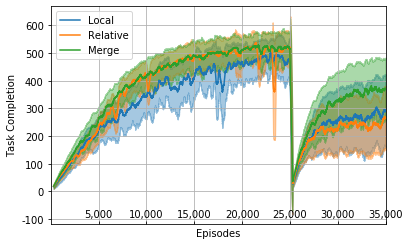

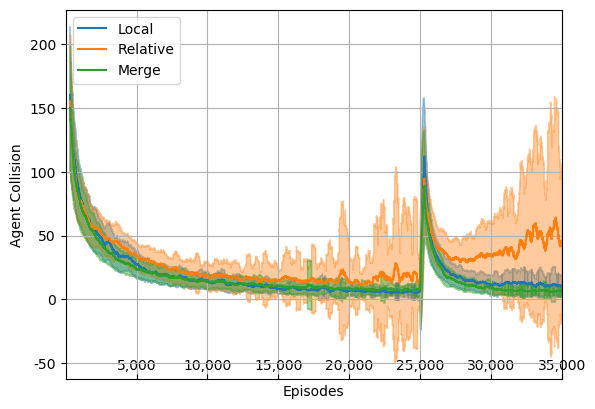

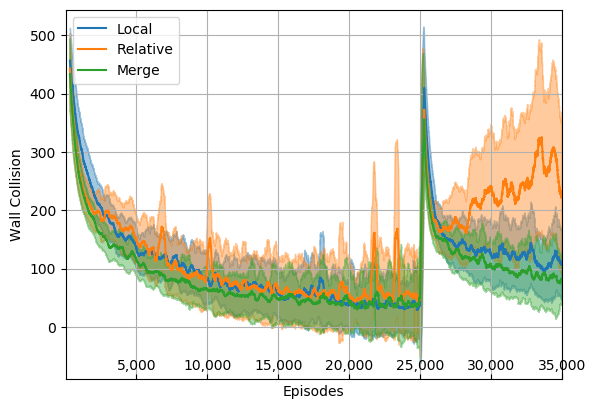

In [13]:
%%time

#Default style colors
#u'#1f77b4', u'#ff7f0e', u'#2ca02c'

#old static spawn
#runNames = ["1586597375_Local_ep25000_staticSpawn", "1587279148_Relative_ep25000_staticSpawn", "1586361267_Merge_ep25000_staticSpawn"]

#random spawn?
#runNames = ["1585664612_Local_4Room_ep25000v29", "1585664948_Relative_4Room_ep25000v29", "1585664518_Merge_4Room_ep25000v29"]

#new static spawn
#runNames = ["1588683304_Local_4Room_ep22000v32_staticSpawn","1588683162_Merge_4Room_ep22000v32_staticSpawn","1588683079_Relative_4Room_ep22000v32_staticSpawn"]

#Static to dynamic
#runNames = ["1589370913_Local_StaticToDynamic", "1589388990_Relative_StaticToDynamic", "1589373060_Merge_StaticToDynamic"]

#Static to dynamic appended with old static spawn
runNames = ["Local_StaticToDynamicAppended", "Relative_StaticToDynamicAppended", "Merge_StaticToDynamicAppended"]
legend = ["Local", "Relative", "Merge"]

saveFolder = "StaticToDynamicAppended2"
grapher = Grapher(runNames = runNames, legend = legend, saveFolder = saveFolder)

roomArangement = "Four Room"
endEp = 35000
startEp = endEp-999
eventNameList = ["Task", "AgentC", "WallC"]
powerList = [None]


#grapher.appendData(runNameTop = "1586597375_Local_ep25000_staticSpawn", runNameBottom = "1589370913_Local_StaticToDynamic")
#grapher.appendData(runNameTop = "1587279148_Relative_ep25000_staticSpawn", runNameBottom = "1589388990_Relative_StaticToDynamic")
#grapher.appendData(runNameTop = "1586361267_Merge_ep25000_staticSpawn", runNameBottom = "1589373060_Merge_StaticToDynamic")
#grapher.render(endEp-1,endEp)
#grapher.graphAllTotalLineChartsSeparately(movingAvgStep = 300, eventTypeList = eventNameList)#need to fix
#grapher.graphAllTotalLineCharts(300)
grapher.graphSeveralTotalLineCharts(300, eventNameList, colorList = [u'#1f77b4', u'#ff7f0e', u'#2ca02c'])
#grapher.graphAllEachAgentLineCharts(300)
#grapher.graphTotalHeatMaps(startEp, endEp, eventNameList, powerList, ignoreArea = 1)#ignores corridor
#grapher.graphTotalHeatMaps(startEp, endEp, eventNameList, powerList, ignoreArea = None)
#grapher.graphEachAgentHeatMaps(startEp, endEp, eventNameList, powerList, ignoreArea = 1)#ignores corridor
#grapher.graphEachAgentHeatMaps(startEp, endEp, eventNameList, powerList, ignoreArea = None)
#grapher.graphEachRoomTime(startEp, endEp, roomArangement = roomArangement)
#grapher.graphTimeSpentWithOneAgentVersusMultipleAgentsInEachRoomDataChart(episodeStart = startEp, episodeEnd = endEp, roomArangement = roomArangement)
#grapher.graphNumberOfDifferentRoomsVisitedByEachAgentChart(episodeStart = startEp, episodeEnd= endEp, movingAvgStep = 100, roomArangement = roomArangement)
#grapher.graphAllEventsPerStep(startEp, endEp, eventList = eventNameList, legendList = legend, movingAvgStep = 5)
#grapher.graphTimeWithinViewRangeForEachAgentAndTotal(3, 1, endEp, 300)#obsrange, epStart, epEnd, movingAvg


In [14]:
"""
runNames = ["1585664612_Local_4Room_ep25000v29", "1585664948_Relative_4Room_ep25000v29", "1585664518_Merge_4Room_ep25000v29"]
legend = ["Local", "Relative", "Merge"]
saveFolder = "dynamic"
grapher = Grapher(runNames = runNames, legend = legend, saveFolder = saveFolder)
grapher.graphAllTotalLineCharts(300)
grapher.graphEachAgentHeatMaps(startEp, endEp, eventNameList, powerList, ignoreArea = None)
grapher.graphEachRoomTime(startEp, endEp, roomArangement = roomArangement)
"""

'\nrunNames = ["1585664612_Local_4Room_ep25000v29", "1585664948_Relative_4Room_ep25000v29", "1585664518_Merge_4Room_ep25000v29"]\nlegend = ["Local", "Relative", "Merge"]\nsaveFolder = "dynamic"\ngrapher = Grapher(runNames = runNames, legend = legend, saveFolder = saveFolder)\ngrapher.graphAllTotalLineCharts(300)\ngrapher.graphEachAgentHeatMaps(startEp, endEp, eventNameList, powerList, ignoreArea = None)\ngrapher.graphEachRoomTime(startEp, endEp, roomArangement = roomArangement)\n'

In [15]:
"""
%%time

#https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
graphMan = GraphingManager()

#-------------------------------------------------------------------------------
#Enter all run names here
#graphMan.read("1583239907_Test")
graphMan.read(["1582965335_Local_task30_ep25000", "1582965335_Relative_task30_ep25000"])

#runNames = ["1578580384_ScottRun", "1578756253_ScottRun"]
#customPaths = ["./recordings/1578580384_ScottRun/ScottRun_csvData", 
#               "./recordings/1578756253_ScottRun/ScottRun_csvData"]
#graphMan.read(runNames, customPath = customPaths)
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
#Set legend for line chart here. Legend and the run names above must be in the same order
legend = ["Local", "Relative"]
#legend = ["Merged"]

#Set your save folder for your graphs here. You'll find the files under recordings/[save folder name]
#graphMan.setSaveFolder("test")
graphMan.setDataBetweenEpisodes(24000,25000)
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
#Uncomment 1 line from below, fill in parameters, and run

#graphMan.graphTotalLineChart(eventType = "Task", interval = -1, movingAvgStep = 300, legendList = legend)
#graphMan.graphEachAgentLineChart(eventType = "Task", interval = -1, movingAvgStep = 300, legendList = legend)

#graphMan.graphEachRoomTime(uniformScale = True, interval = -1) #Only for the 6 room environment

#graphMan.graphTotalAreaChart(interval = -1, movingAvgStep = 300)
#graphMan.graphEachAgentAreaChart(interval = -1, movingAvgStep = 300)

#graphMan.graphTotalHeatMaps(eventName = "Task", uniformScale = True, color = "Blues", interval = -1, power = 3)
#graphMan.graphEachAgentHeatMaps(eventName = "Task", uniformScale = True, color = "Blues", interval = -1, power = 3, scaleMin = None, scaleMax = None)

#graphMan.graphEmptyRooms(3)

graphMan.render(10000)
"""

'\n%%time\n\n#https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html\ngraphMan = GraphingManager()\n\n#-------------------------------------------------------------------------------\n#Enter all run names here\n#graphMan.read("1583239907_Test")\ngraphMan.read(["1582965335_Local_task30_ep25000", "1582965335_Relative_task30_ep25000"])\n\n#runNames = ["1578580384_ScottRun", "1578756253_ScottRun"]\n#customPaths = ["./recordings/1578580384_ScottRun/ScottRun_csvData", \n#               "./recordings/1578756253_ScottRun/ScottRun_csvData"]\n#graphMan.read(runNames, customPath = customPaths)\n#-------------------------------------------------------------------------------\n\n\n#-------------------------------------------------------------------------------\n#Set legend for line chart here. Legend and the run names above must be in the same order\nlegend = ["Local", "Relative"]\n#legend = ["Merged"]\n\n#Set your save folder for your graphs here. You\'ll find the files under recordings/[sav

In [16]:
"""
#Parameters:
#  eventType/eventName
#  "Move": When the agent just moves without crashing or completing tasks
#  "Task": When agent completes task
#  "WallC": When agent crashes into wall
#  "AgentC": When agent crashes into another agent

#  interval: Splits the datasets into x number of episodes and makes separate graphs for each
#  leave as -1 for no interval

# movingAvgStep: Bigger number means charts look smoother
# leave as -1 for no moving average

# uniformScale: when graphing multiple charts, the x and/or y axis is made the same range between charts

"""


"""
def buildModel():
    OBSERVATION_SPACE_VALUES = (35, 20, 3)
    RMSPROP_LEARNING_RATE = 0.00001
    model = Sequential()
    model.add(Conv2D(32, (2, 2), padding="same",input_shape=OBSERVATION_SPACE_VALUES))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(64, (2, 2), padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    #https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras
    model.add(Flatten(input_shape=(5, 5, 16)))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(4, activation='linear'))  # ACTION_SPACE_SIZE = how many choices (4)
    rmsProp = optimizers.RMSprop(RMSPROP_LEARNING_RATE)
    model.compile(loss="mse", optimizer=rmsProp, metrics=['accuracy'])
    return model

# Saves diagram of given keras model 
# showShapes describes input and output shapes
def saveModelDiagram(model, filePath='model.png', showShapes = True):
    plot_model(model, to_file=filePath, show_shapes = showShapes)
"""

'\ndef buildModel():\n    OBSERVATION_SPACE_VALUES = (35, 20, 3)\n    RMSPROP_LEARNING_RATE = 0.00001\n    model = Sequential()\n    model.add(Conv2D(32, (2, 2), padding="same",input_shape=OBSERVATION_SPACE_VALUES))\n    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))\n\n    model.add(Conv2D(64, (2, 2), padding="same"))\n    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))\n\n    #https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras\n    model.add(Flatten(input_shape=(5, 5, 16)))\n    model.add(Dense(100))\n    model.add(Activation(\'relu\'))\n    model.add(Dense(4, activation=\'linear\'))  # ACTION_SPACE_SIZE = how many choices (4)\n    rmsProp = optimizers.RMSprop(RMSPROP_LEARNING_RATE)\n    model.compile(loss="mse", optimizer=rmsProp, metrics=[\'accuracy\'])\n    return model\n\n# Saves diagram of given keras model \n# showShapes describes input and output shapes\ndef saveModelDiagram(model, filePath=\'model.png\', showShapes = True):\n    plot_